In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from HGNN_ns import *
from util import smiles_to_pretrained_gnn_data, reaction_center_config, reshape_tensor
import sys
sys.path.append('/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection')
import scipy.sparse as sp
from sklearn.preprocessing import normalize
import nocd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torchmetrics import Accuracy, Precision, Recall, F1Score, Specificity
from rdkit.Chem import Draw
from rdkit import Chem
from IPython.display import display
#from pipeline import FourLayerMLP

DGL installed!
MolVS is not installed, which is required for candidate ranking


In [28]:
class FourLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FourLayerMLP, self).__init__()
        
        # Define layers
        layers = []
        current_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            current_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(current_size, output_size))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        # Apply layers with ReLU activation between each layer
        return self.model(x)
def hyperedge2clique(ns_data_dir, chem_ns_data_dir, datapath, encoding):
    name2id = {}  # V
    id2name = []  # V
    id2nid = []  # list of list, max: V * V
    id2nid_set = []  # list of list, max: V * V
    id2ncount = []  # V
    n_node = 0
   # file_write = filename
    if with_chem_ns == False:
        filename = os.path.join(ns_data_dir, f'{datapath}_{encoding}.pt')
    else:
        filename = os.path.join(chem_ns_data_dir, f'{datapath}_{encoding}.pt')
    
    #filename = os.path.join('/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_balanced', f'{filename}_{args.encoding}.pt')
    if not os.path.isfile(filename):
        raise Exception("No such file when loading hypergraph: %s" % filename)
    hyperedge = torch.load(filename)
    features = hyperedge['node_feat']
    edge_node_pair = hyperedge['EdgeNodePair']
    n_hyperedges = hyperedge['N_edges']
    edge_dict = {}
    for index, pair in enumerate(edge_node_pair):
        if pair[0] in edge_dict:
            edge_dict[pair[0]].append(pair[1])
        else:
            edge_dict[pair[0]] = []
            edge_dict[pair[0]].append(pair[1])
            
    for index, (edge,nodes) in enumerate(edge_dict.items()):
        
        # Add each node to the dictionaries if not present
        node_ids = []
#         # get rid of the hyperedge with only one node
#         if len(nodes)==1:
#             continue
        for node in nodes:
            if node not in name2id:
                name2id[node] = len(name2id)
                id2name.append(node)
                id2nid.append([])
            node_ids.append(name2id[node])
        
        # Create edges for every pair in the hyperedge (forming a clique)
        for i in range(len(node_ids)):
            for j in range(i + 1, len(node_ids)):
                id1, id2 = node_ids[i], node_ids[j]
                if id2 not in id2nid[id1]:  # Check to avoid duplicate edges
                    id2nid[id1].append(id2)
                if id1 not in id2nid[id2]:  # Check to avoid duplicate edges
                    id2nid[id2].append(id1)
    
    # Convert to sets for quick access and calculate node degrees
    id2nid_set = [set(nodes) for nodes in id2nid]
    id2ncount = [len(nid) for nid in id2nid]
    n_node = len(id2name)
    all_edges = []
    for i in range(len(id2nid)):
        for j in range(len(id2nid[i])):
            all_edges.append([i, id2nid[i][j]])
    
    row_ind = [edge[0] for edge in all_edges]
    col_ind = [edge[1] for edge in all_edges]
    row_ind1 = [edge[0] for edge in edge_node_pair]
    col_ind1 = [edge[1] for edge in edge_node_pair]
    data = [1] * len(all_edges)
    data1 = [1] * len(edge_node_pair)
    adjacency_matrix = sp.csr_matrix((data, (row_ind, col_ind)), shape=(n_node, n_node))
    #node_feature_matrix = sp.csr_matrix(features)
    node_feature_matrix = None
    if encoding == 'no_feat':
        #D = 512
        node_feature_matrix = sp.csr_matrix(features)#np.random.randn(n_node, D))
    elif encoding == "ecfp6_feat":
        node_feature_matrix = sp.csr_matrix(features)
    elif encoding == "ecfp4_feat":
        node_feature_matrix = sp.csr_matrix(features)
    else:
        raise ValueError('The encoding is not defined')

    community_affilication_matrix = sp.csr_matrix((data1,(row_ind1, col_ind1)), shape=(n_hyperedges, n_node)).T.toarray()
    
    return adjacency_matrix, node_feature_matrix, community_affilication_matrix

def mean_aggregator(node_features, node_lists):
    aggregated_features = []
    for i, node_list in enumerate(node_lists):
        num_nodes, feature_dim = node_features.shape
        all_features = node_features[node_list]
        aggregated_features.append(all_features.mean(dim=0))
    
    return torch.stack(aggregated_features)

def compute_metrics(y_true, y_pred):
    y_pred_binary = (np.array(y_pred).astype(float) > 0.5).astype(float)  # Convert probabilities to binary predictions
    accuracy = accuracy_score(y_true, y_pred_binary)
    specificity_metric = Specificity(task='binary')
    specificity = specificity_metric(torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.int))
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, specificity, f1, auc


In [29]:
def get_reactants_smiles(X_batch, node_smiles_list):
    reactant_smiles_list = []
    for X in X_batch:
        temp = [node_smiles_list[i] for i in X]
        reactant_smiles_list.append(temp)
    return reactant_smiles_list
def get_predicted_rxn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path):
    A, X, Z_gt = hyperedge2clique(ns_data_dir, chem_ns_data_dir, data_path, encoding)
    N, K = Z_gt.shape
    if with_chem_ns == False:
        filename = os.path.join(ns_data_dir, f'{data_path}_{encoding}.pt')
    else:
        filename = os.path.join(chem_ns_data_dir, f'{data_path}_{encoding}.pt')
    hyperedge = torch.load(filename)
    node_smiles_list = hyperedge['node_smiles_list']
    hidden_sizes = [128]    # hidden sizes of the GNN
    weight_decay = 1e-2     # strength of L2 regularization on GNN weights
    dropout = 0.5           # whether to use dropout
    batch_norm = True       # whether to use batch norm
    lr = 1e-3               # learning rate
    #max_epochs = args.pretrain_epochs        # number of epochs to train
    display_step = 25       # how often to compute validation loss
    balance_loss = True     # whether to use balanced loss
    stochastic_loss = True  # whether to use stochastic or full-batch training
    batch_size = 20000      # batch size (only for stochastic training)
    x_norm = normalize(X)  # node features
    x_norm = nocd.utils.to_sparse_tensor(x_norm).to(device)
    gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).to(device)
    gnn.load_state_dict(torch.load(gnn_model_path, weights_only=True))
    gnn.eval()
    adj_norm = gnn.normalize_adj(A)
    with torch.no_grad():
        output_feat = gnn(x_norm.to(device), adj_norm.to(device))
    input_size, hidden_size, output_size = output_feat.shape[1], [64,32], 1
    mlp = FourLayerMLP(input_size, hidden_size, output_size).to(device)
    mlp.load_state_dict(torch.load(mlp_path, weights_only=True))
    mlp.eval()
    data = torch.load(split_path)
    training = data['ground_train'] +  data['train_only_pos']
    validation = data['ground_valid'] + data['valid_only_pos']
    testing = data['test_pos'] 
    testing_pos = data['test_pos'] 
    neg_testing_mns = [list(fs) for fs in data['test_mns']]
    neg_validation_mns = [list(fs) for fs in data['valid_mns']]
    neg_training_mns = [list(fs) for fs in data['train_mns']]
    neg_testing_cns = [list(fs) for fs in data['test_cns']]
    neg_validation_cns = [list(fs) for fs in data['valid_cns']]
    neg_training_cns = [list(fs) for fs in data['train_cns']]
    neg_testing_sns = [list(fs) for fs in data['test_sns']]
    neg_validation_sns = [list(fs) for fs in data['valid_sns']]
    neg_training_sns = [list(fs) for fs in data['train_sns']]
    
    l = len(training)
    l1 = len(validation)
    l2 = len(testing)
    
    if with_chem_ns == True:
        neg_testing_chem_neg = [list(fs) for fs in data['test_neg']]
        neg_validation_chem_neg = [list(fs) for fs in data['valid_only_neg']]
        neg_training_chem_neg = [list(fs) for fs in data['ground_neg_train']]
    
        neg_testing = neg_testing_mns[:l2//8] + neg_testing_cns[:l2//8] + neg_testing_sns[:l2//8] + neg_testing_chem_neg[:l2//8]
        neg_validation = neg_validation_mns[:l1//8] + neg_validation_cns[:l1//8] + neg_validation_sns[:l1//8] + neg_validation_chem_neg[:l1//8]
        neg_training = neg_training_mns[:l//8] + neg_training_cns[:l//8] + neg_training_sns[:l//8] + neg_training_chem_neg[:l//8]
    else:
        neg_testing = neg_testing_mns[:l2//6] + neg_testing_cns[:l2//6] + neg_testing_sns[:l2//6]
        neg_validation = neg_validation_mns[:l1//6] + neg_validation_cns[:l1//6] + neg_validation_sns[:l1//6]
        neg_training = neg_training_mns[:l//6] + neg_training_cns[:l//6] + neg_training_sns[:l//6]
        
    training_label = [1] * len(training) + [0] * len(neg_training)
    validation_label = [1] * len(validation) + [0] * len(neg_validation)
    testing_label = [1] * len(testing) + [0] * len(neg_testing)
    training += neg_training
    testing += neg_testing
    validation += neg_validation
    X_train, y_train = training, training_label
    X_test, y_test = testing, testing_label
    sampler = nocd.sampler.get_hyperedge_sampler(X_train, y_train, batch_size=100000)
    test_sampler = nocd.sampler.get_hyperedge_sampler(X_test, y_test, batch_size=100000)
    #feat_matrix_stacks = []
    #labels = []
    all_y_true = []
    all_y_pred = []
    all_reactant_smiles_list = []
    for X_batch, y_batch in test_sampler:
       # optimizer.zero_grad()

        # Move batch data to device
        X_batch, y_batch = X_batch, torch.tensor(y_batch, dtype=torch.float32).to(device)
        #testing_reactions = 
        reactant_smiles_list = get_reactants_smiles(X_batch, node_smiles_list)
        batch_feat = mean_aggregator(output_feat, X_batch)
        #feat_matrix_stacks.append(batch_feat)
        #labels.append(y_batch)
        y_pred = mlp(batch_feat).squeeze()
        y_batch = y_batch.squeeze()
        all_y_true.extend(y_batch.cpu().numpy())
        all_y_pred.extend(y_pred.detach().cpu().numpy())
        all_reactant_smiles_list.extend(reactant_smiles_list)
    accuracy, precision, recall, specificity, f1, auc = compute_metrics(all_y_true, all_y_pred)
    print(recall)
    y_pred_binary = (np.array(all_y_pred).astype(float) > 0.5).astype(float)
    return all_y_true, y_pred_binary, all_reactant_smiles_list

    
    
    

In [30]:
data_path = 'hyperedge_1000'
encoding = 'ecfp6_feat'
gnn_model_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_1000_ecfp6_feat/best_pretrained_gnn_model.pth'
mlp_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_1000_ecfp6_feat/best_mlp_model.pth'
with_chem_ns = True
ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
chem_ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
split_path = './data_neg_balanced_smiles/splits/hyperedge_1000split2.pt'
device = 'cuda:0'

all_y_true, all_y_pred, smiles_list = get_predicted_rxn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)
#get_2D_tsne_gnn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)

0.28350515463917525


/tmp/1560437.1.gpu/ipykernel_778602/3523198079.py:118: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  specificity = specificity_metric(torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.int))


In [32]:
sum(all_y_pred)

79.0

[Cl-].CC(=O)OCC1OC(Br)C(OC(C)=O)C(OC(C)=O)C1OC(C)=O.CCCC[N+](CCCC)(CCCC)Cc1ccccc1.CC(=O)c1sccc1O.[K+].O.ClCCl.O=C([O-])[O-]


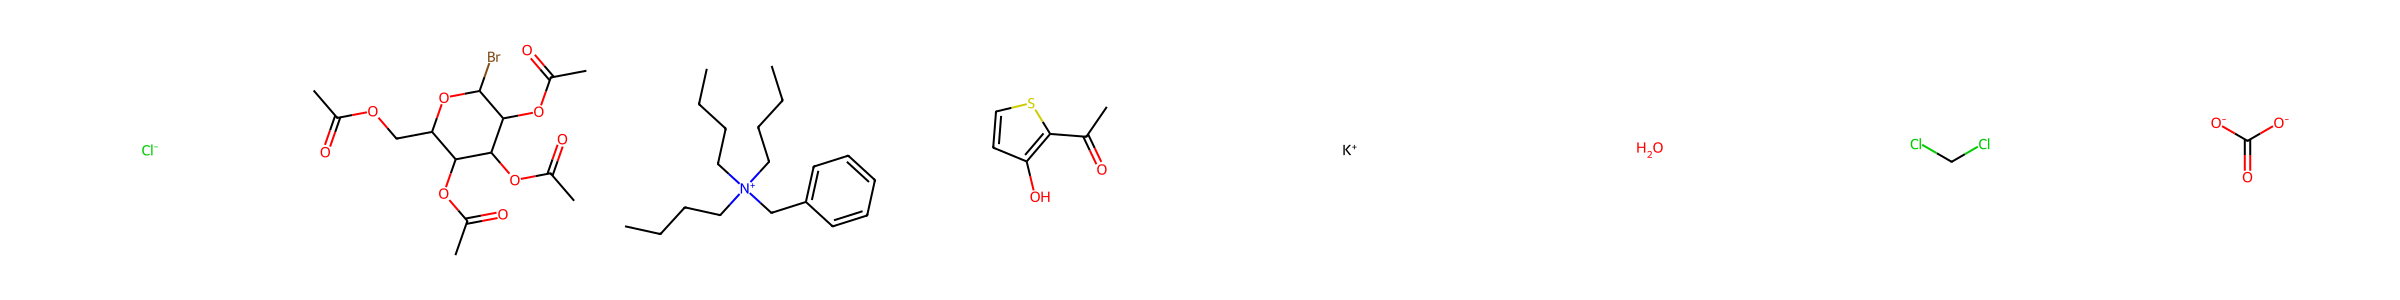

[BH4-].[Na+].NC(=O)c1ccc(Oc2cc[c]cc2)nc1.NCc1ccccc1.CO.[CH]=O


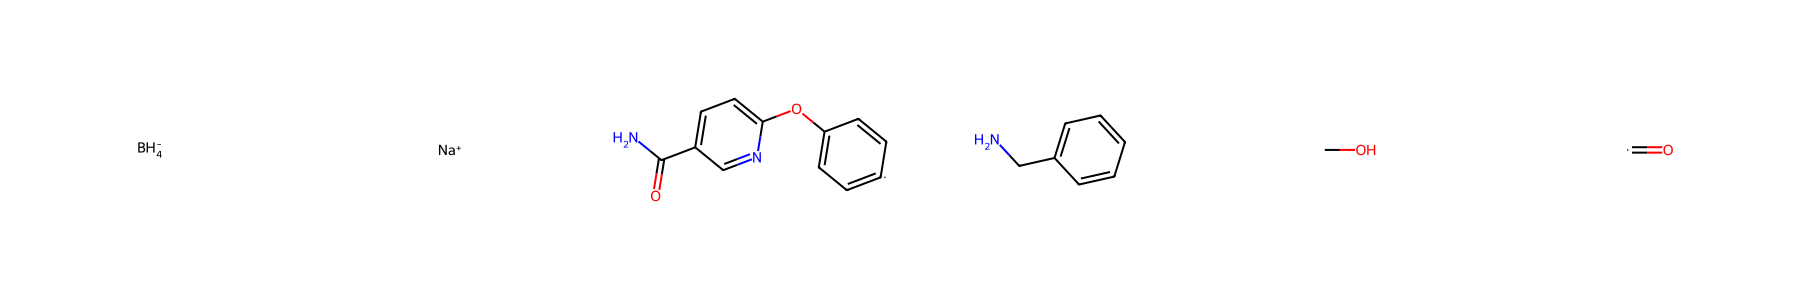

CCCCC(C)I.Nc1ccccc1O


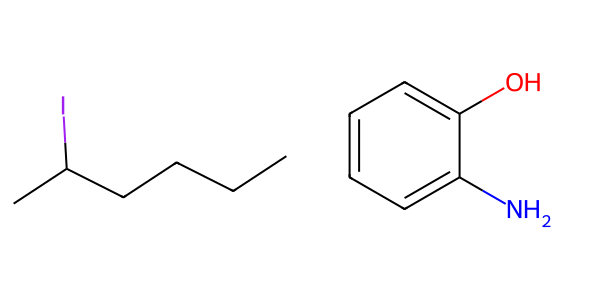

C1CCOC1.[Na+].O=C([O-])O.CCOC(C)=O.CCN(CC)CCCNC.Nc1cc(Oc2ccc(NC(=S)NC(=O)Cc3ccc(F)cc3)cc2F)ccn1.CCN(CC)CC.CN(C)C=O.O=C(Cl)Oc1ccccc1


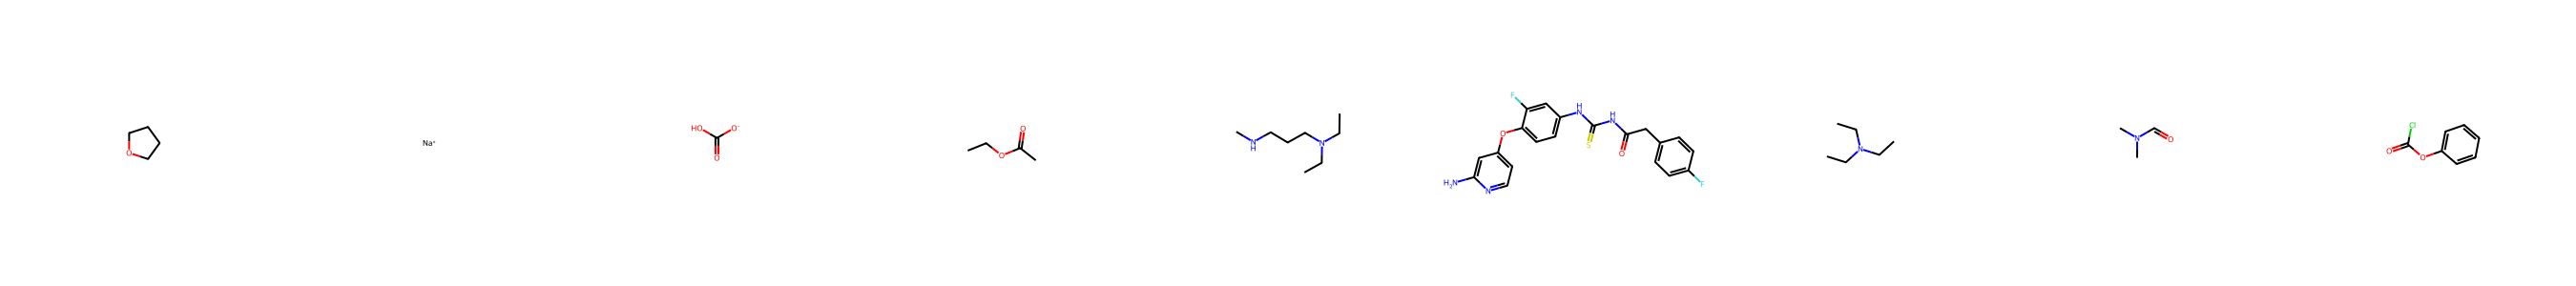

O=C(N(Cc1ccnc2ccccc12)C1CCNC(Cc2ccccc2)C1)C(F)(F)F.Cl.O=C(O)Cc1ccccn1.O=C1OCCN1P(=O)(Cl)N1CCOC1=O.CCN(CC)CC


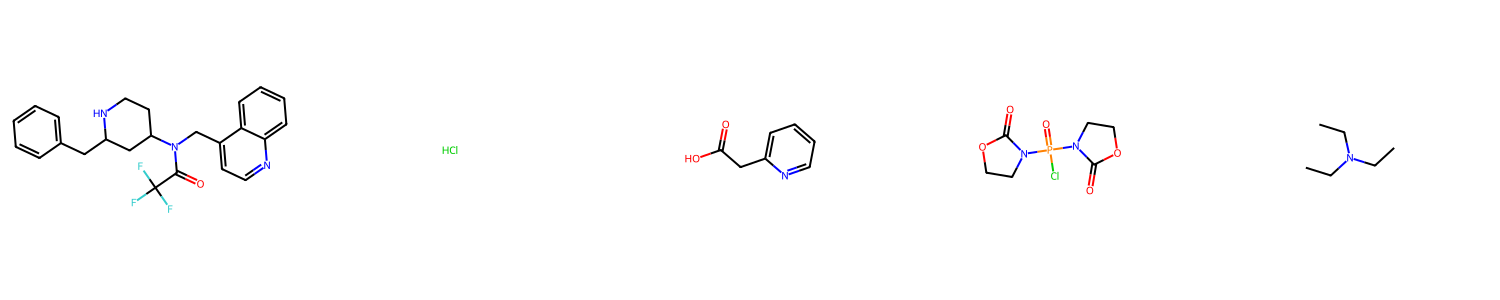

C#Cc1cnn2c(C(F)F)cc(-c3ccc(C(F)(F)F)cc3)nc12.CC(C)(CO)NS(=O)(=O)c1ccc(Cl)s1


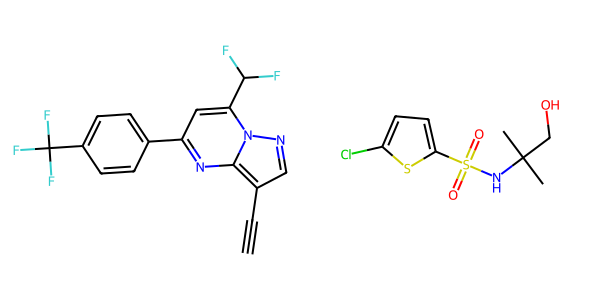

CC(C)(C)c1ccccc1.[Cl-].O.[Al+3].Cl.[CH]C(Cl)(Cl)Cl.[O]


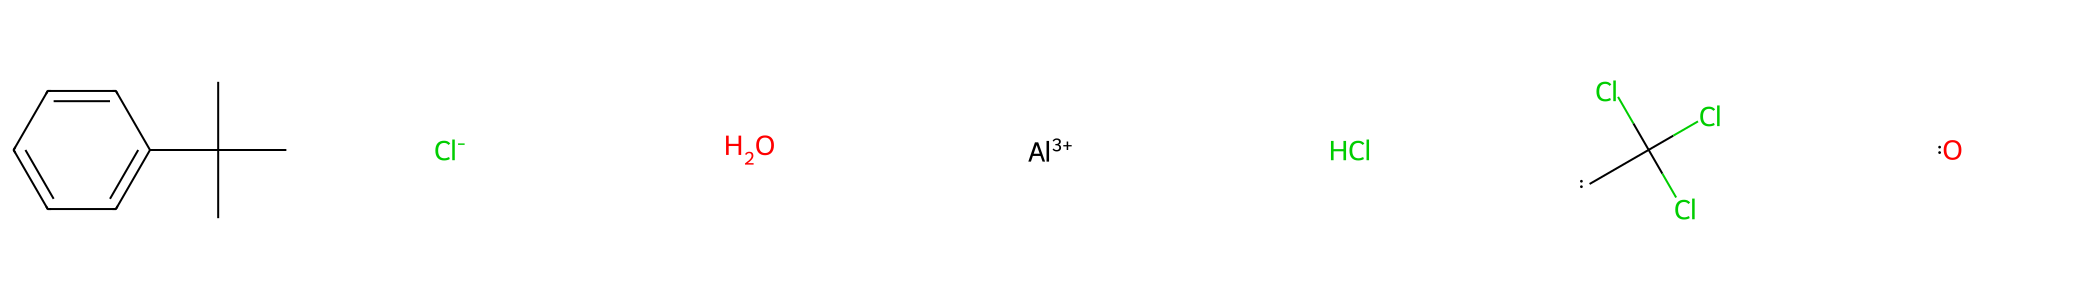

COc1cc2c(c(Cl)c1OC)CCNCC2c1ccccc1.C=O.[Na+].[OH-].O=CO


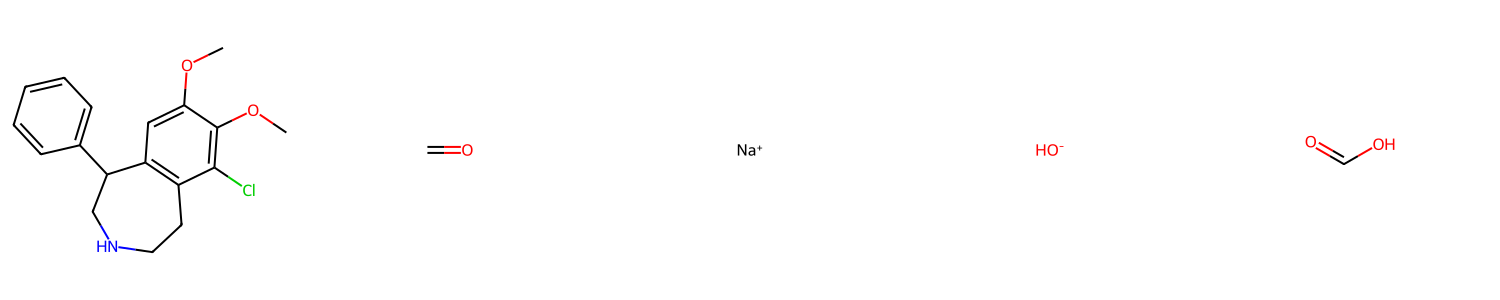

CC(C)(C)OC(=O)N1CC(OS(C)(=O)=O)CC1C(=O)NC1(C#N)CC1.CS(=O)(=O)O.FC(F)(F)Oc1ccccc1S


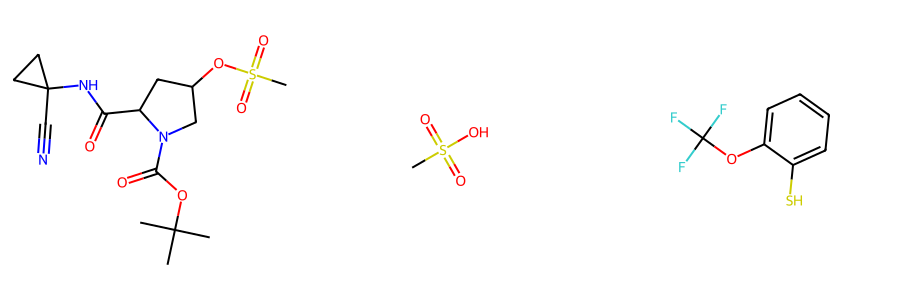

CCOC(=O)c1cnc2c(OC)cccc2c1Cl.CCCCN


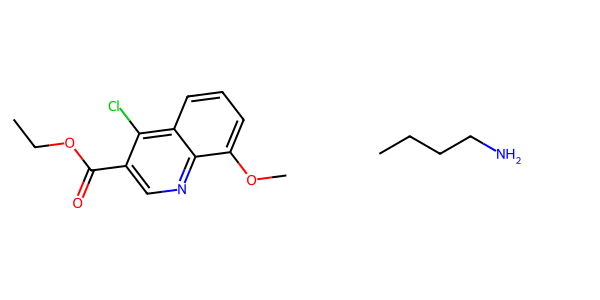

CO.Cl.CC(=O)OCC1CCC(=N)N1.N


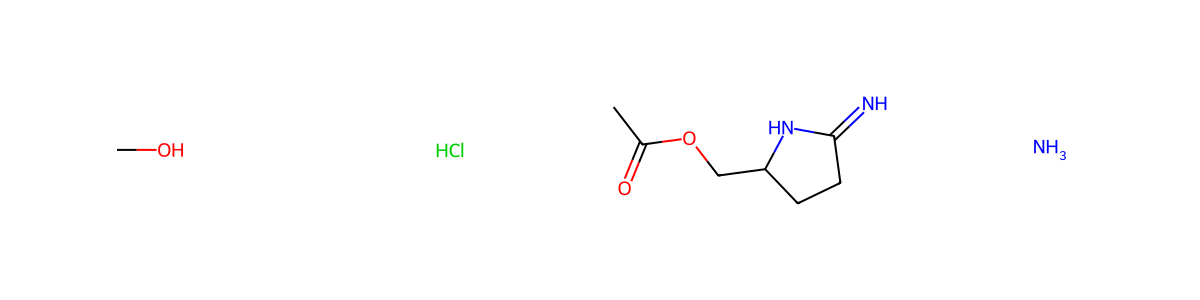

[NH2].CCOP(=O)(CC(O)CCl)CC1CCCCC1.CCO.C[CH]c1ccc(Cl)c(Cl)c1


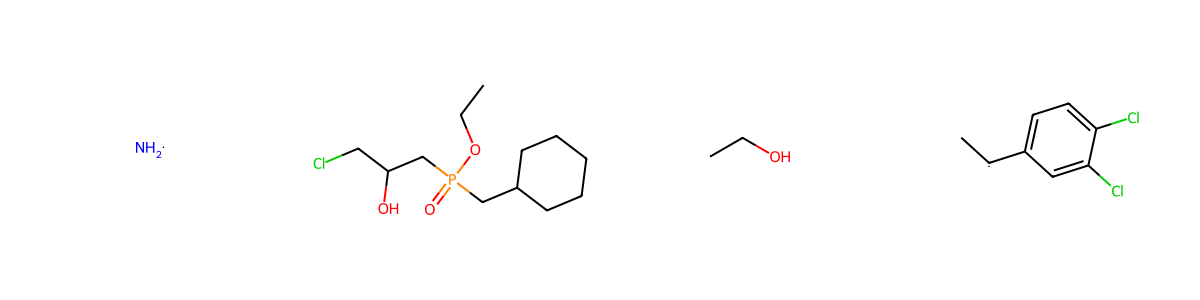

c1ccc(P(c2ccccc2)c2ccccc2)cc1.ClC(Cl)(Cl)Cl.CC(Cl)Cl.NC(=O)c1cccnc1F


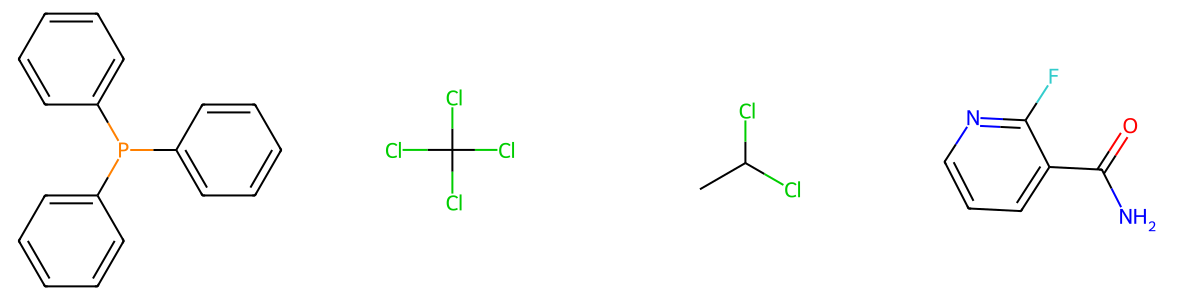

O=CO.CCn1cc(C(=O)O)c(=O)c2cc(F)c(-c3ccc(N)cc3)cc21


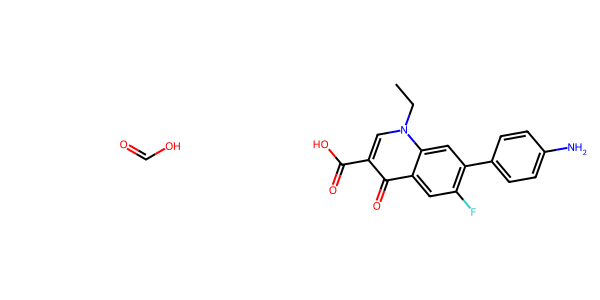

NN.CCO.O.Clc1ccc(CCCBr)cc1.ClCCl.[K].O=C1NC(=O)c2ccccc21.CN(C)C=O


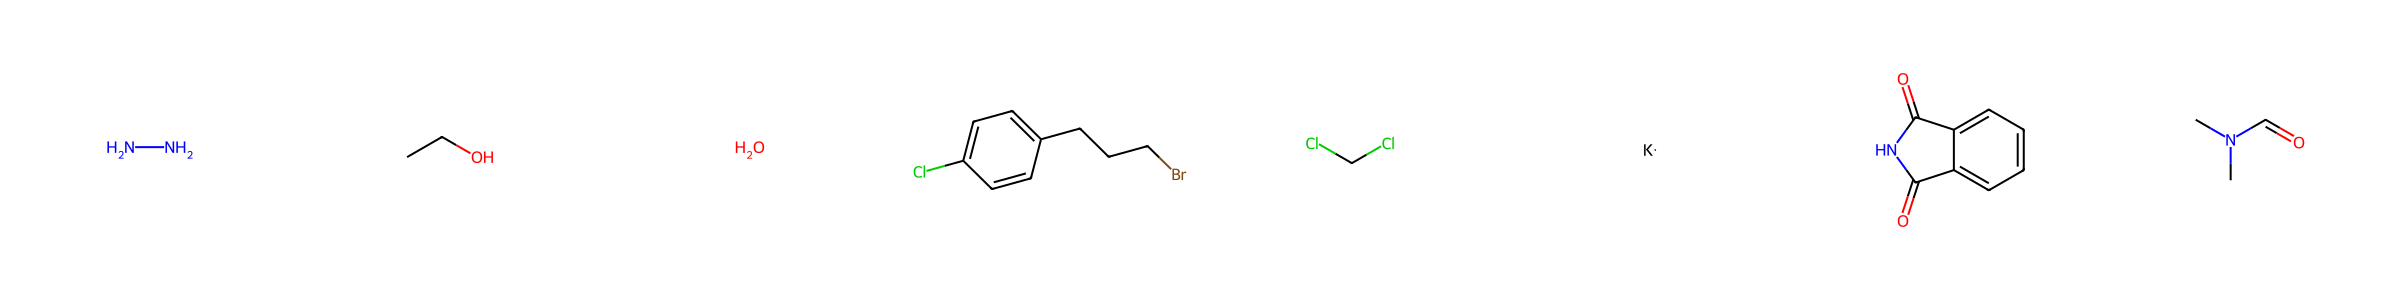

CC(C)(C#N)N=NC(C)(C)C#N.Cc1ccc(C#N)cc1Br.ClC(Cl)Cl.O=[C]CCC(=O)[N]Br


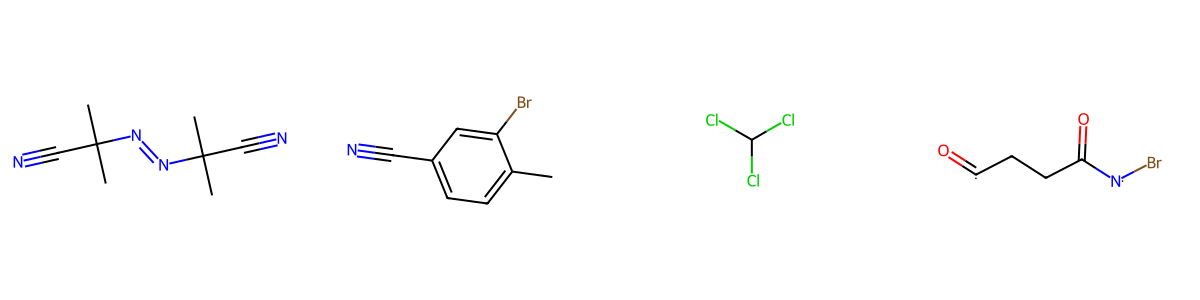

[Na+].[OH-].Fc1cc(Cl)cnc1F.O


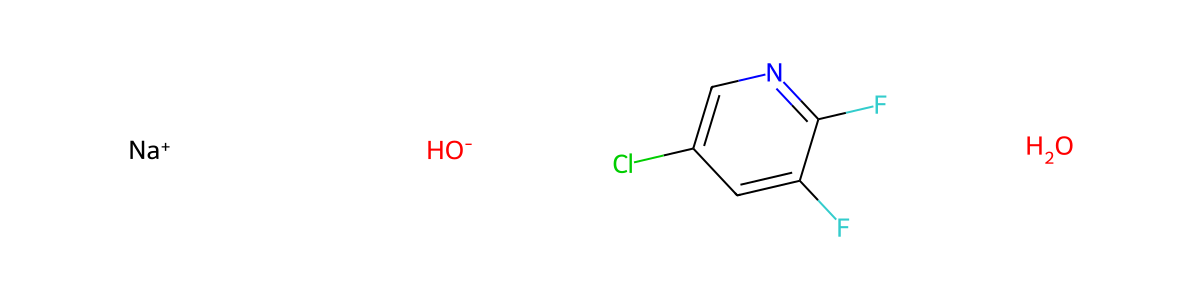

O.CCCCN1C(=O)CNC1=O.CC(O)O.O=Cc1ccc(C2OC=CO2)cc1.Cc1ccc(S(=O)(=O)O)cc1.c1ccccc1


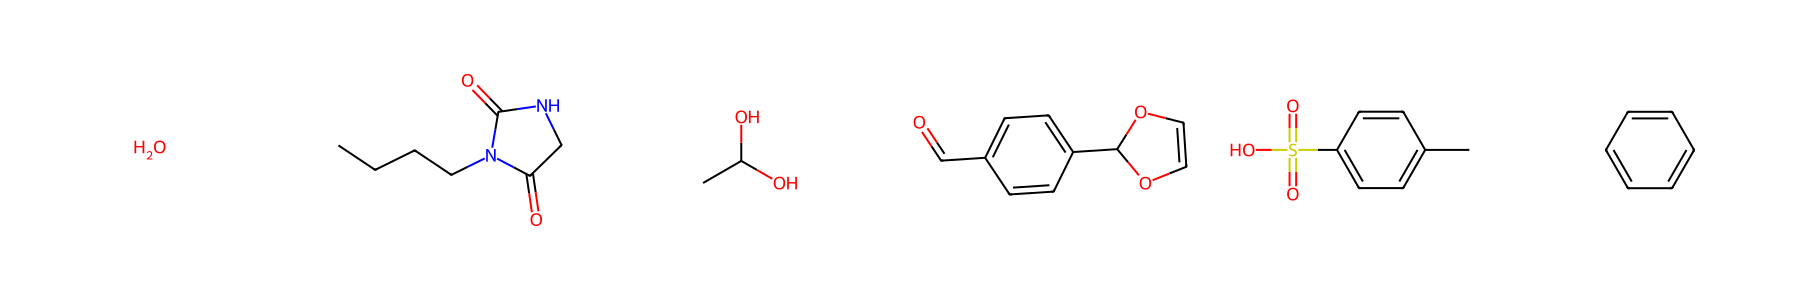

[CH]1Cc2ccccc2Sc2ccccc21.[K+].ClCCl.O=C([O-])[O-].[Cl].OCCBr


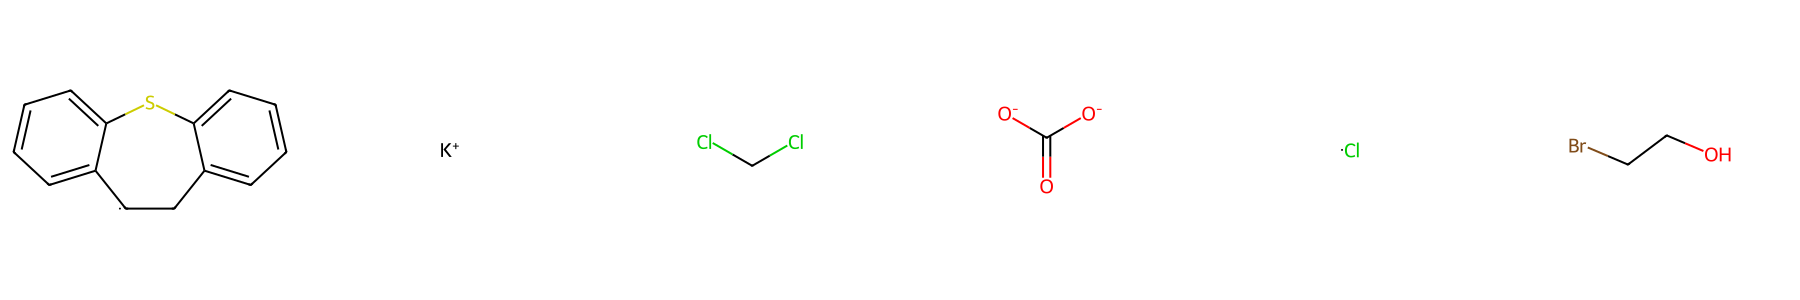

[Na+].CCO.O.Cl[Pd]Cl.COCCOC.OB(O)c1ccc(F)cc1.c1ccc(P(c2ccccc2)c2ccccc2)cc1.O=C([O-])[O-].COCCn1cc(Br)sc1=NC(=O)C12CC3CC(CC(C3)C1)C2


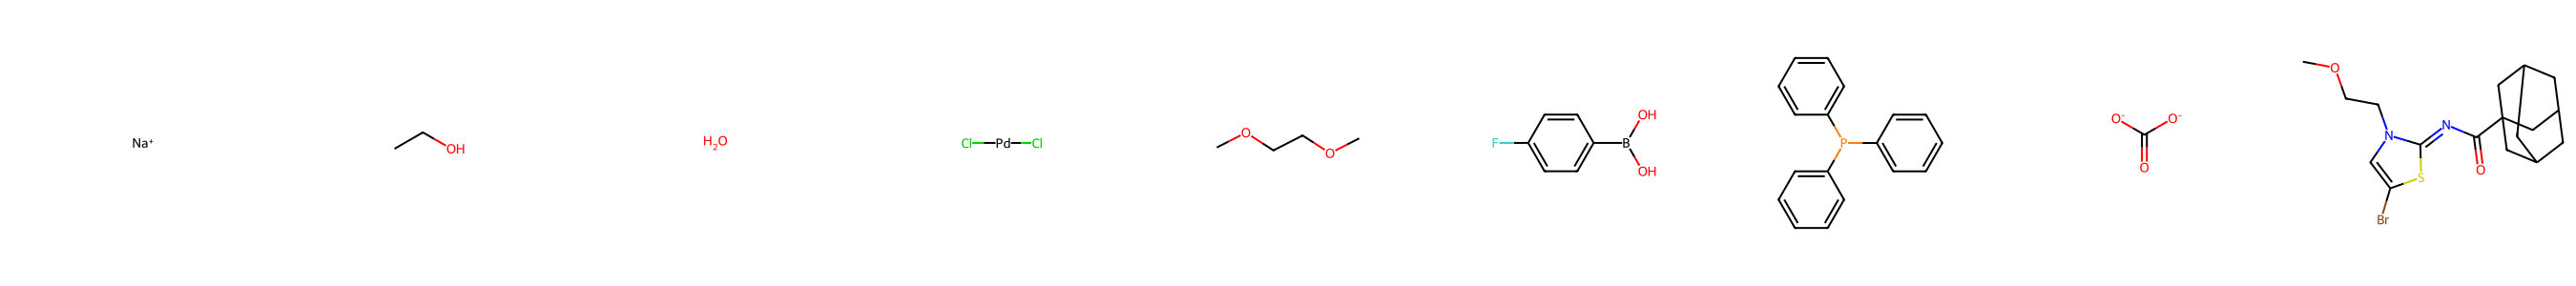

C1CCOC1.CC(=O)Nc1nc(C)c(-c2csc(C(=O)Cl)n2)s1.ClCCl.OC1CCNCC1.CCN(CC)CC


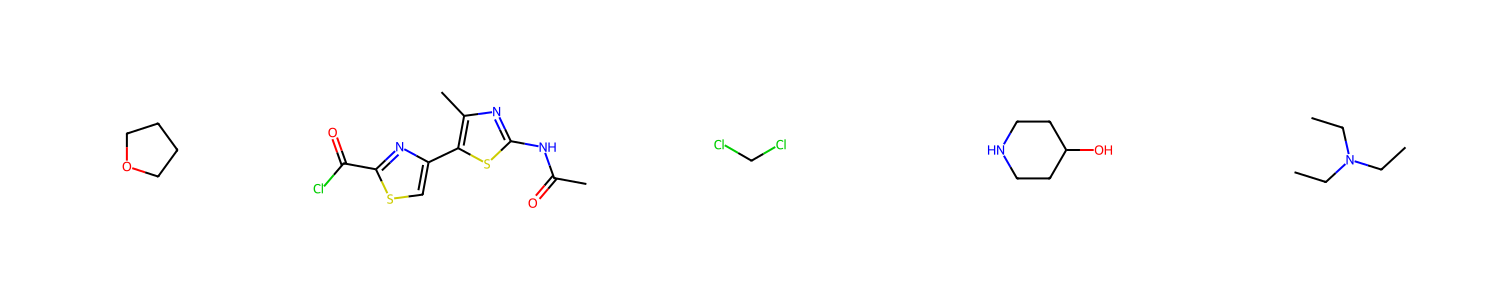

C1CCOC1.[Na+].O.CCCCCC.CC(=O)[O-].[Li]C.CC(C)(O)c1cccc(Br)c1.[Li]CCCC.CCOCC.NOS(=O)(=O)O.O=S=O


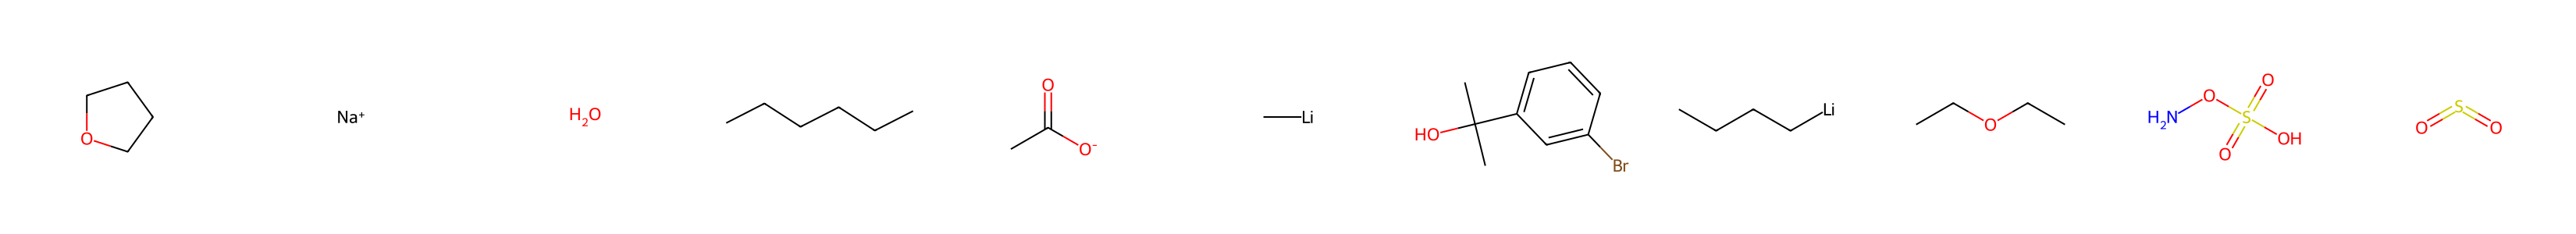

N#Cc1cccc(C2C3=C(CCCC3=O)NC(O)(C(F)(F)F)C2C(=O)O)c1.Cc1ccccc1.O.Cc1ccc(S(=O)(=O)O)cc1


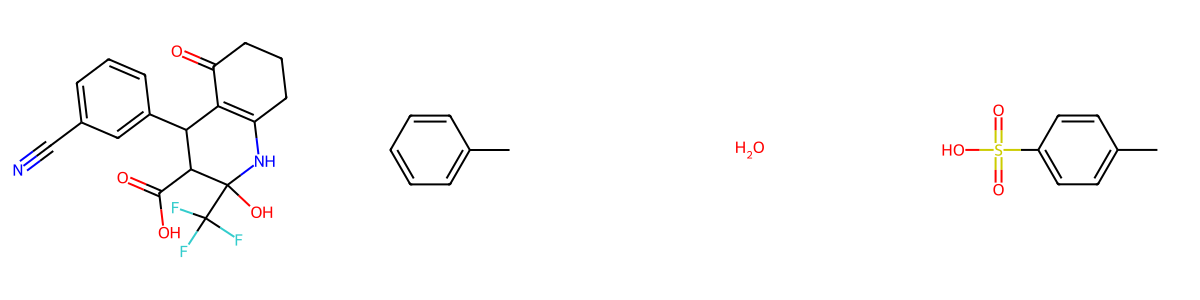

[K+].ClCC1(CCl)CO1.O=C([O-])[O-].Oc1ccc(Cl)cc1.CC(C)=O


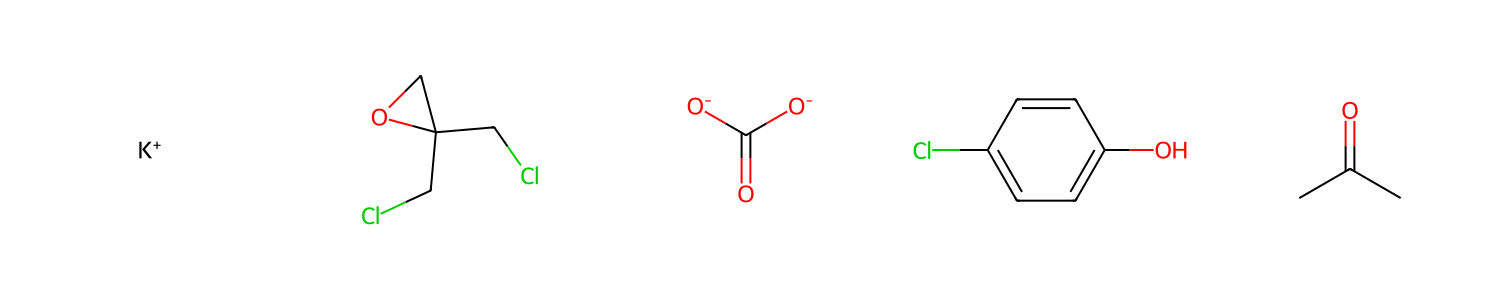

C1CCOC1.CC(C)[N-]C(C)C.Cl.[Li+].[O].[C]=O.Fc1cccc(-c2ccccc2)n1


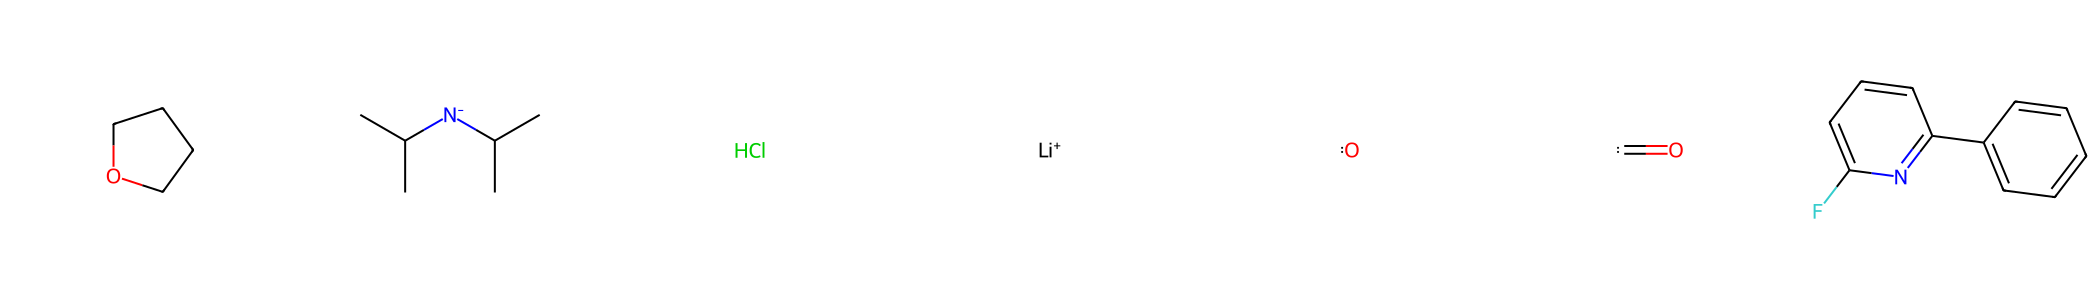

NS(=O)(=O)Cl.CCN(CC)CC.CC1(C)OC2C(CO)OC(n3cnc4c(C#Cc5ccccc5)ncnc43)C2O1.CC#N


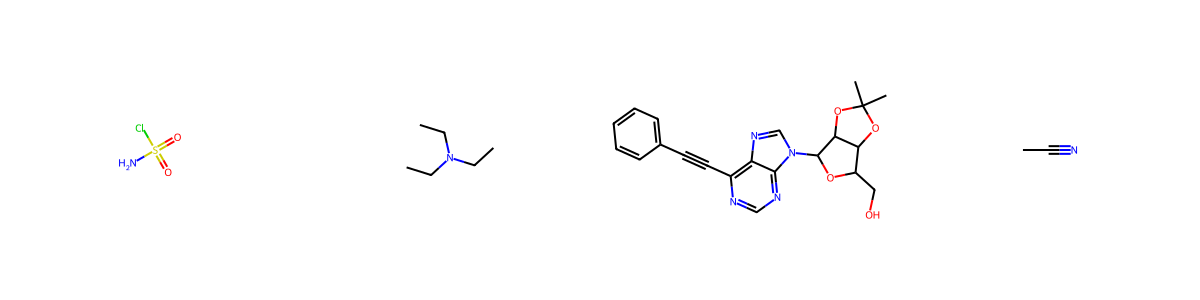

O=[N+]([O-])c1cnc2cccnc2c1O.CN(C)C=O.O.O=P(Cl)(Cl)Cl


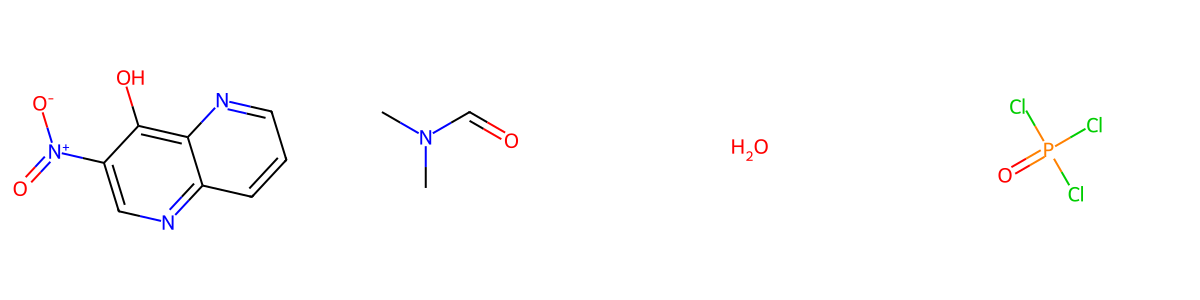

OCCCC1(c2ccccc2)OCCO1.O=C(n1ccnc1)n1ccnc1.O.[Br].CC#N.[CH2]C=C


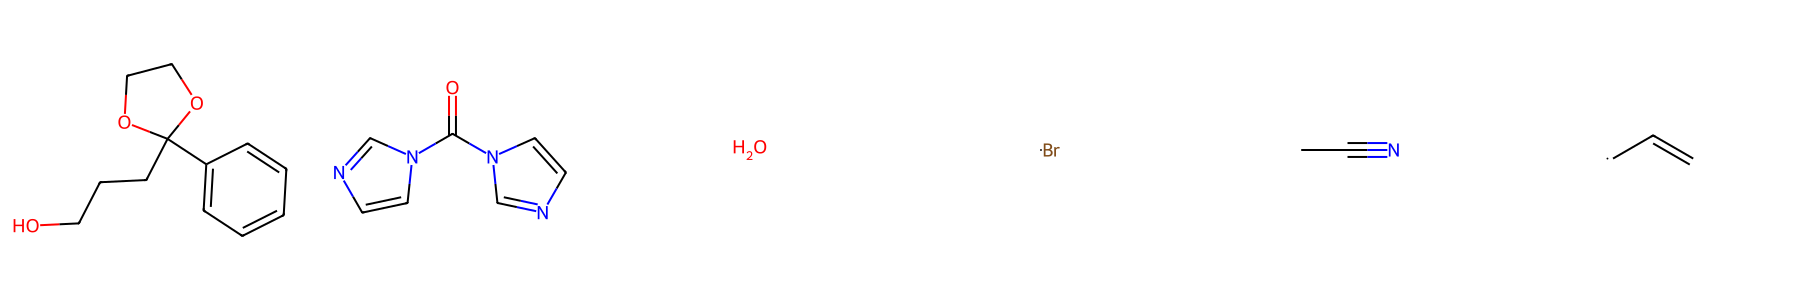

C1CCNCC1.CCN(C(C)C)C(C)C.CS(C)=O.O=C1NC(=O)C(=Cc2cccc(Br)n2)S1


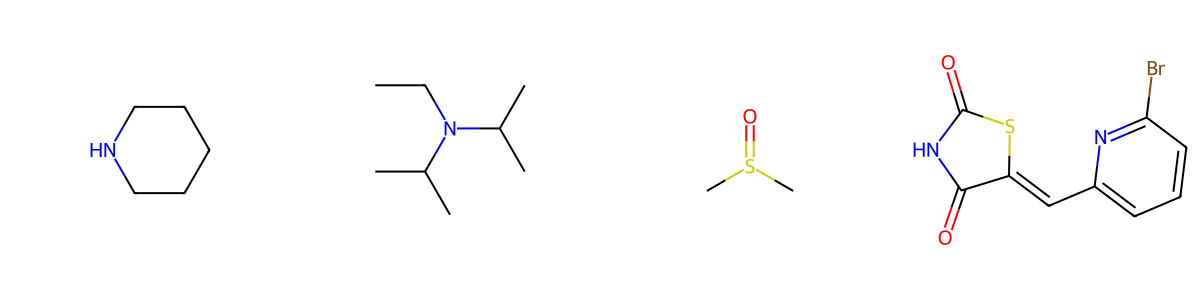

[K+].c1ccncc1.CC(C)C(=O)Cl.Nc1cn2c(c(OCc3ccccc3)c1=O)C(=O)N(Cc1ccc(F)c(Cl)c1)CC2.O=S(=O)([O-])O.ClC(Cl)Cl


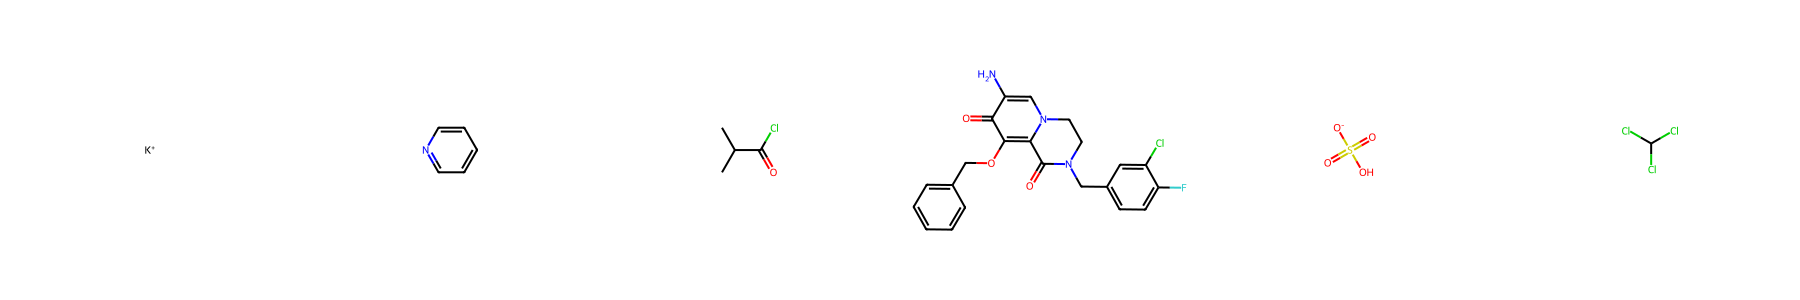

[BH4-].[Na+].CCO.O.CC(C)(C)c1onc(-c2ccc(Cl)cc2Cl)c1C(=O)c1cccnc1


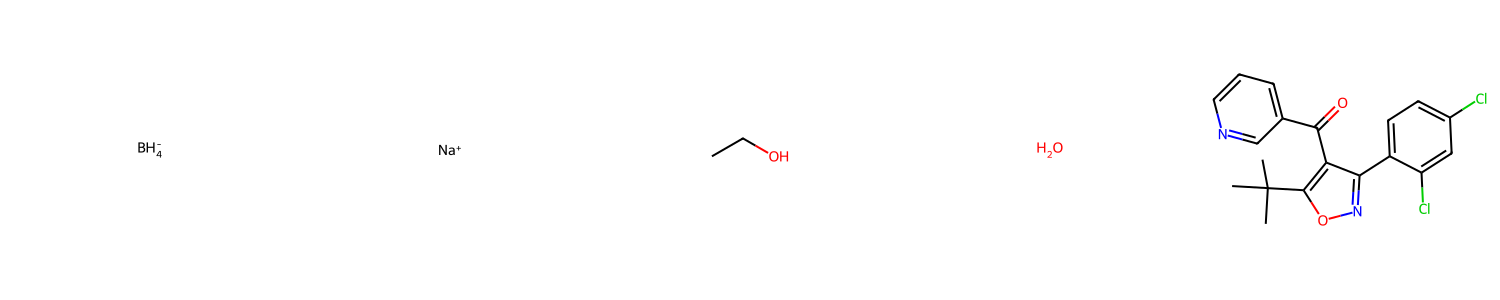

O=C(O)C(F)(F)F.CC(C)(C)OC(=O)N1CCN2CC(COc3ccc(F)cc3)CCC2C1.O


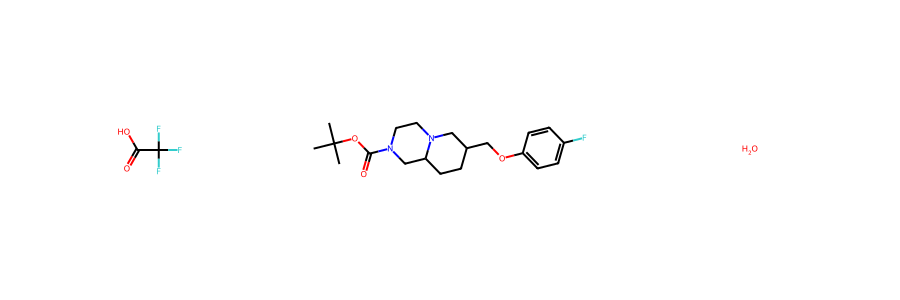

CC(C)(N)CN.[S].[C]c1cnc2c(c1)N(S(=O)(=O)c1ccc(C(F)(F)F)cc1)CCO2.[N].Cc1ccccc1


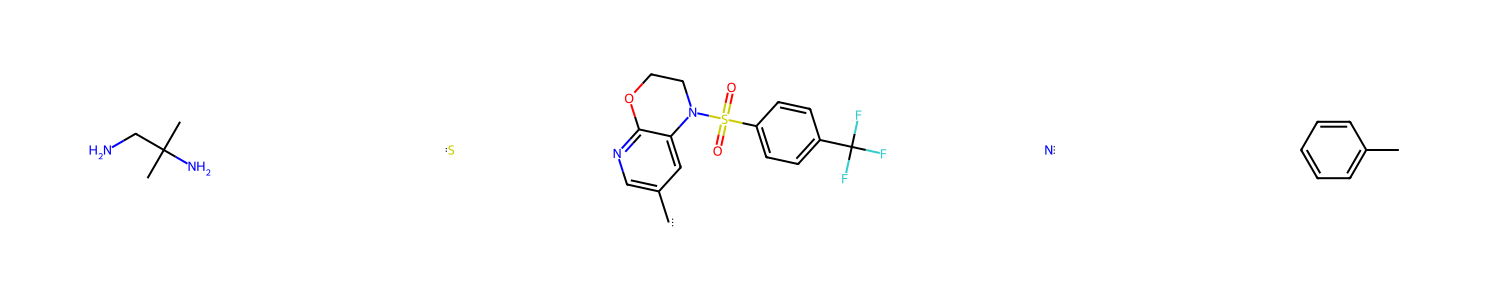

[CH3].O.OCCO.Cc1ccc(S(=O)(=O)O)cc1.O=[C]c1ccc(O)c([N+](=O)[O-])c1.c1ccccc1


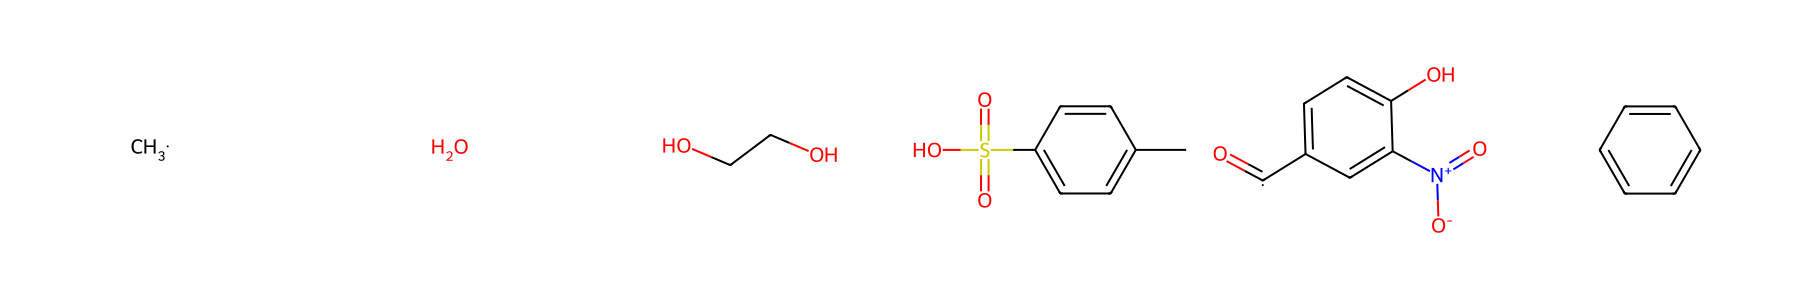

CN(C)C(=O)Cl.CC(C)N1CCC(Oc2cc3cc(C(=O)N4CCNCC4)[nH]c3cc2Cl)CC1


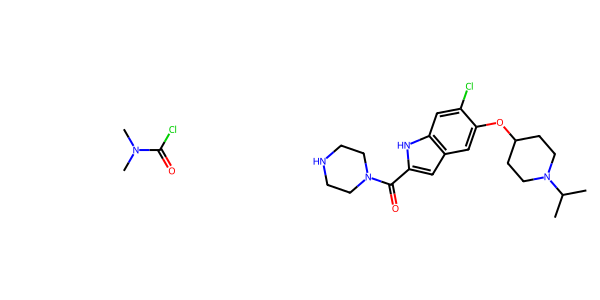

NCCCCN.Nc1ccccc1NC(=O)c1ccc(Cl)nc1


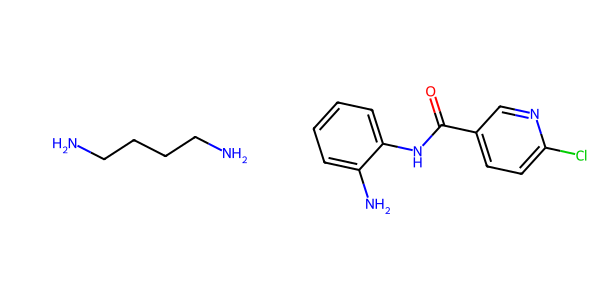

C1CCOC1.CCOC(C)=O.CC(C)(N)CC(=O)O.CN(C)c1ccncc1.CCN(CC)CC.CC(=O)OC(C)=O


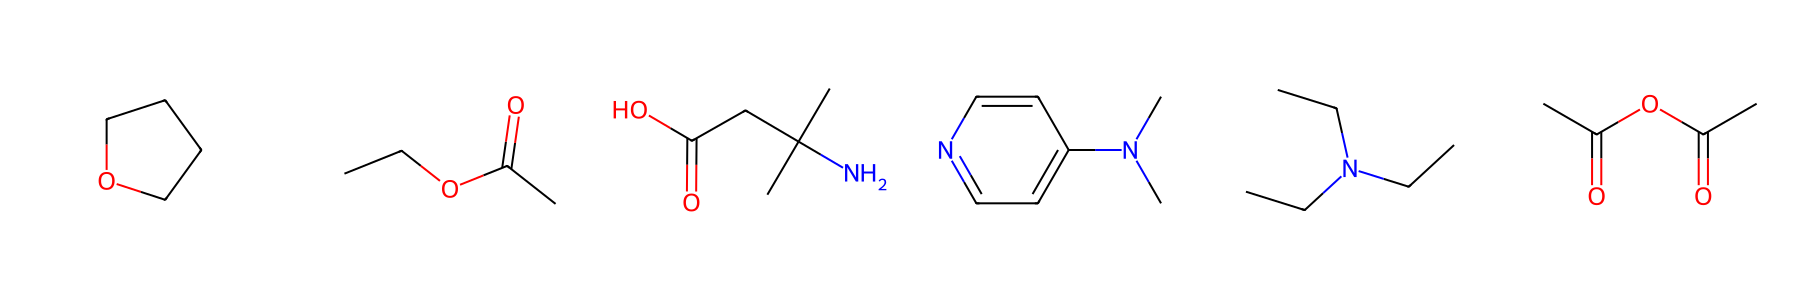

[O-].O.[Fe].CC(=O)O.COC(=O)COc1ccccc1Oc1cc(-n2c(=O)cc(C(F)(F)F)n(C)c2=O)c(F)cc1[N+]=O


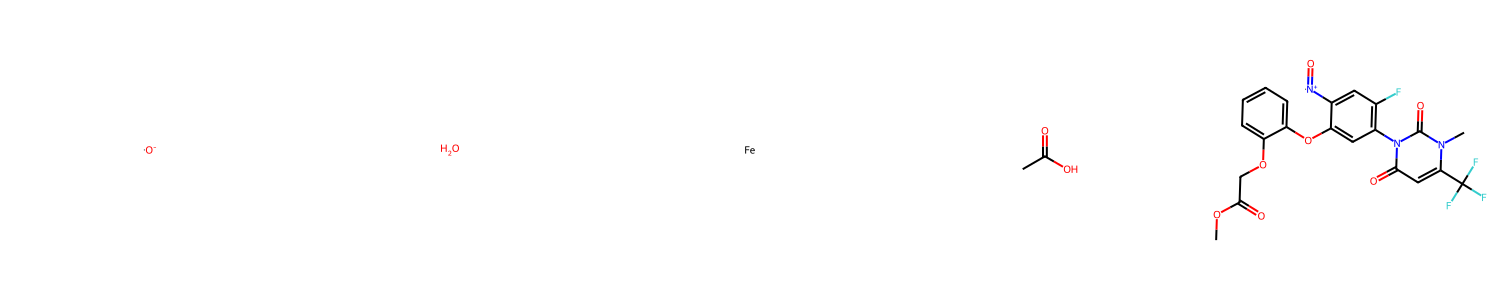

[OH-].[Na+].O.CO.Cl.CCCNC(=O)c1cc(C(=O)OC)cc(-c2ccccc2)c1.CC(C)=O


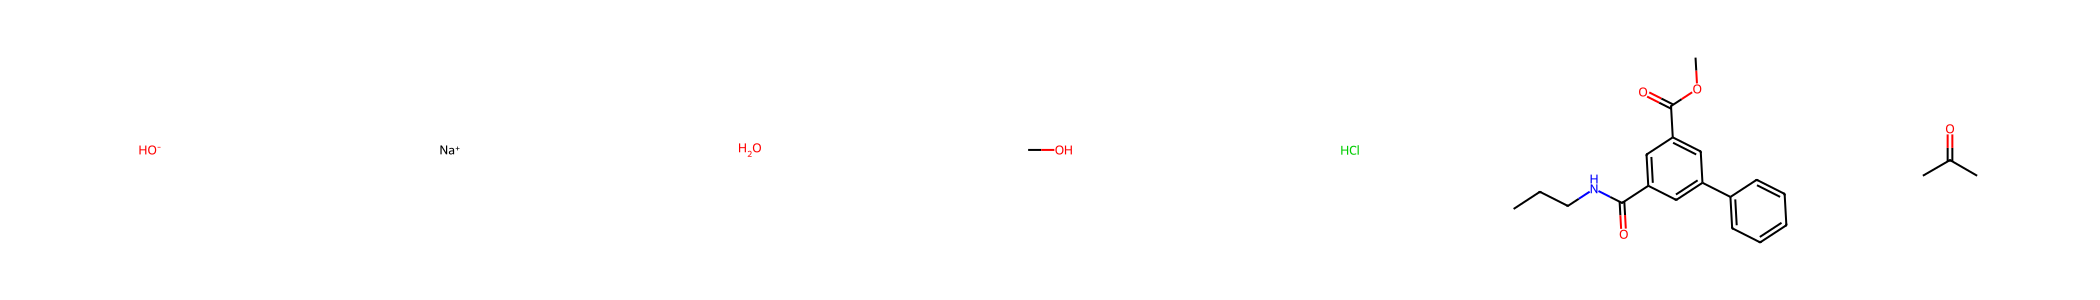

[Cl-].[Na+].Oc1cc(Br)cnc1I.O.CCOC(C)=O.[NH4+].CI.[H-].CN(C)C=O


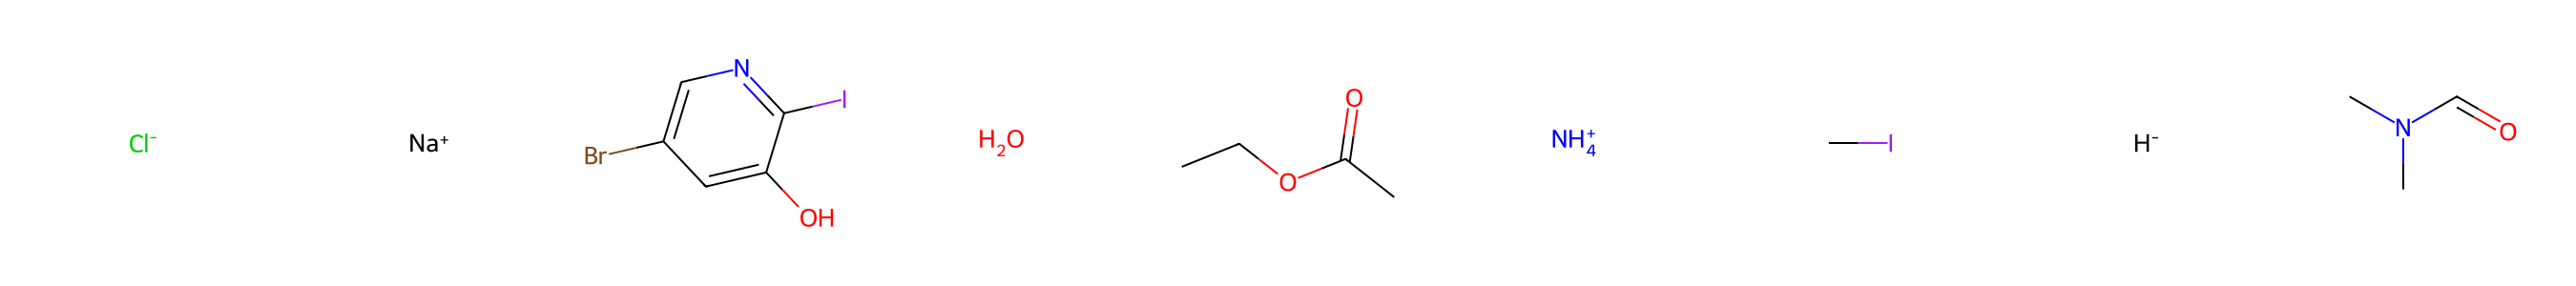

CCN1C(=O)C(F)(F)CN(C2CCCC2)c2nc(Nc3ccc(C(=O)O)cc3)ncc21.[Cl-].[CH3].O.C[N]C(N(C)C)=[N+]1N=[N+]([O-])c2ncccc21.CCOC(C)=O.[NH4+].CCN(C(C)C)C(C)C.CN(C)C=O.F[P-](F)(F)(F)(F)F


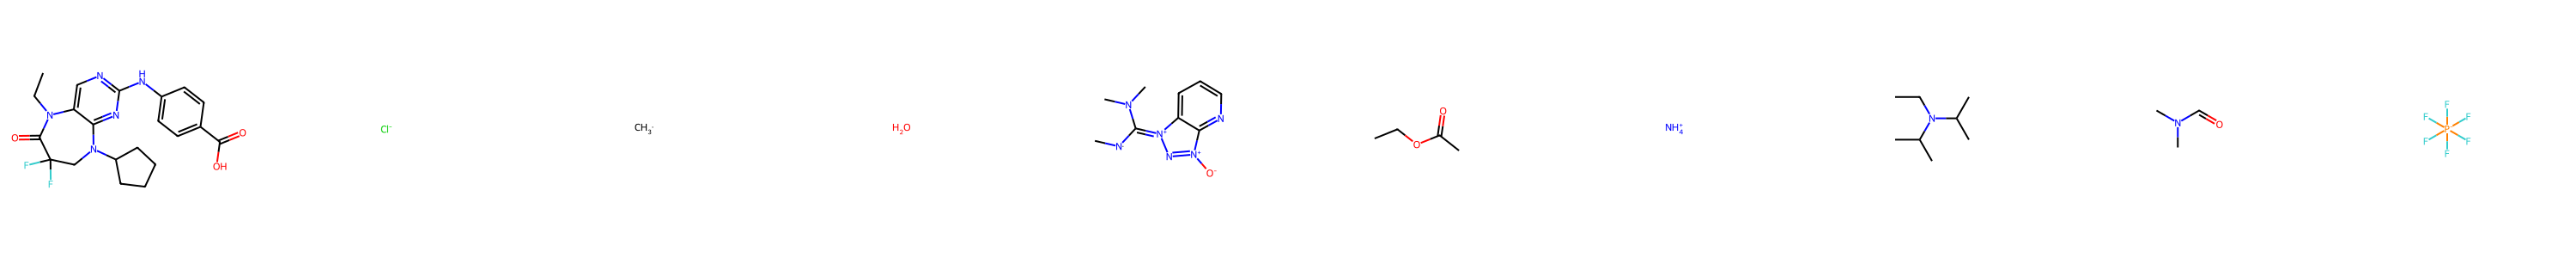

CCC(=O)NC1CC(n2cnc3c(NC(CC)CC)nc(Cl)nc32)C(O)C1O.NCCN1CCCCC1


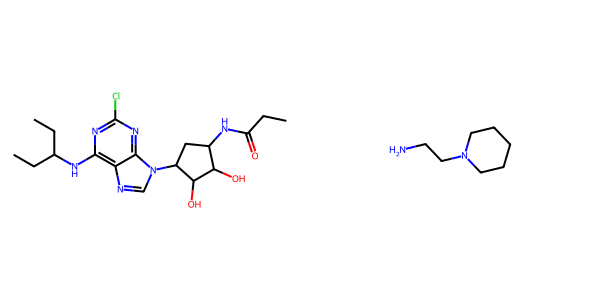

CCOC(C)=O.Cc1ncc2ccc([N+][O-])cc2n1.[H][H].[O]


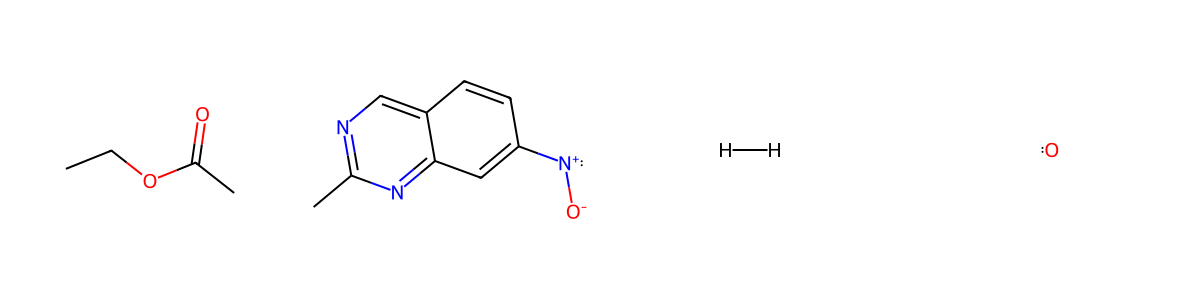

[BH4-].COc1ccc(CC(=O)N(Cc2ccc(C)cc2)C2CCN(C(=O)OC(C)(C)C)CC2)cc1.O=Cc1ccc(O)cc1.CCO.CC(=O)OC(C)=O


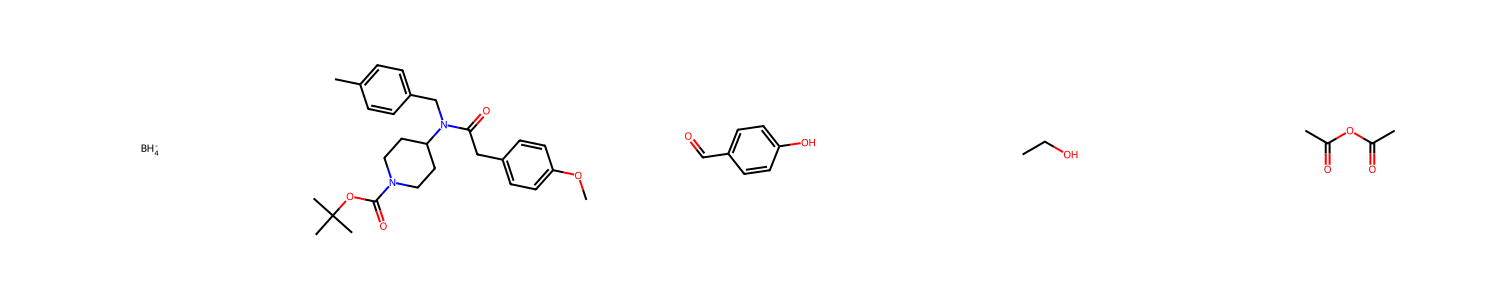

O.CC(=O)c1ccc(O)c([N+](=O)[O-])c1.OCCO.Cc1ccc(S(=O)(=O)O)cc1.c1ccccc1


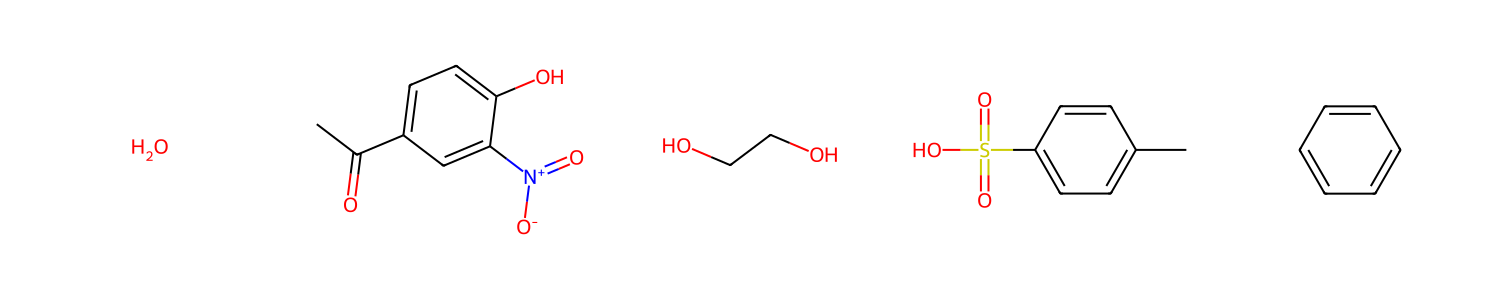

CCO.[K+].O=[N+]([O-])c1ncc[nH]1.O=C([O-])[O-].[CH2]CCCC1[CH]O1


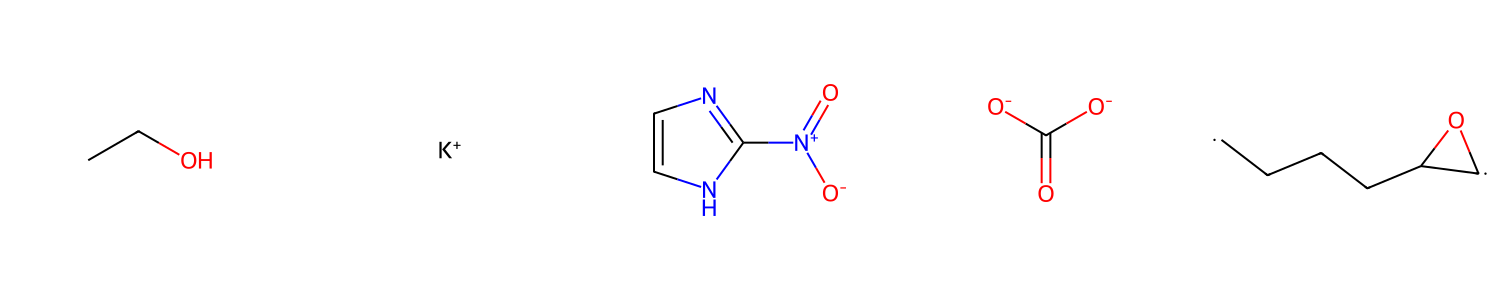

C1CCNC1.CCOC(=O)N1CC[C]C(C)C1.[O].c1ccccc1


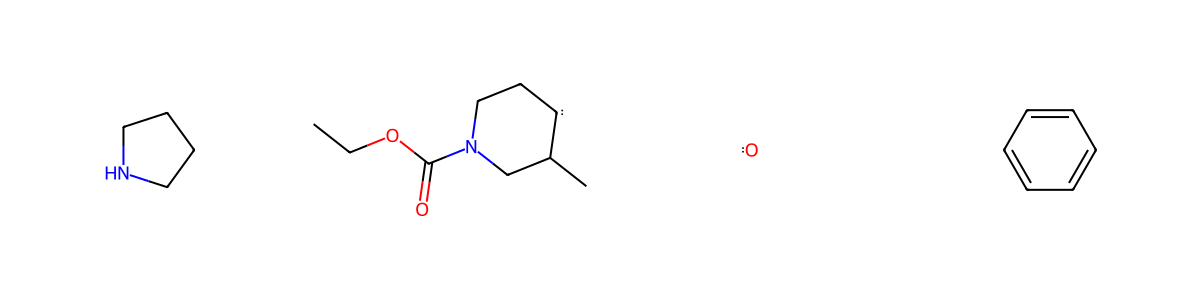

NC(=O)c1cc(Br)cc2c(C3CCN(S(=O)(=O)CCCCl)CC3)n[nH]c12.[Na+].[I-].[K+].CNC.O=C([O-])[O-].CN(C)C=O


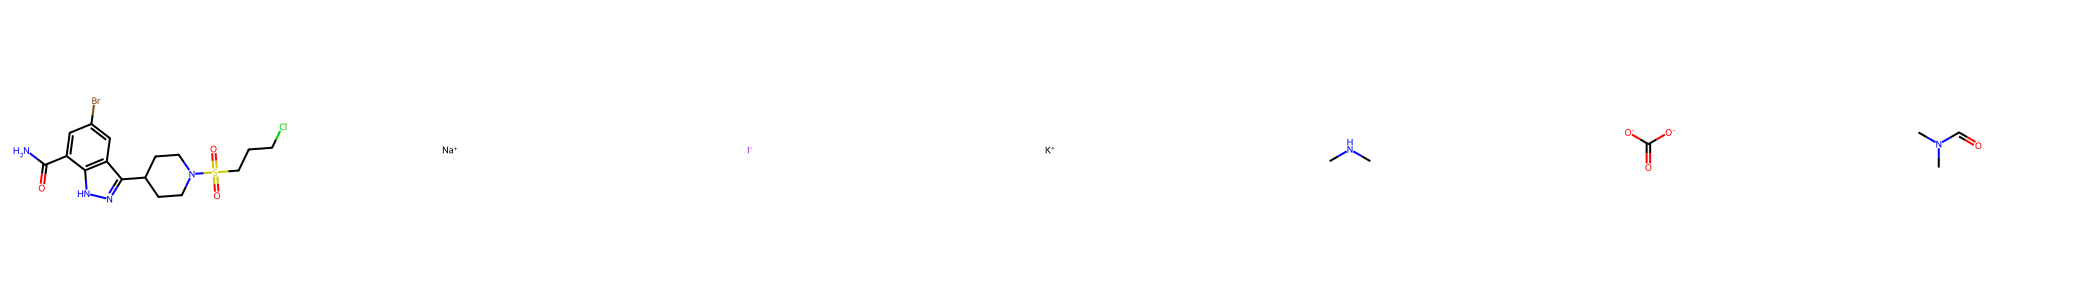

CNS(=O)(=O)c1ccccc1Nc1nc(Cl)ncc1Cl.Nc1ccc2c(c1)CNC(=O)CCN2C(=O)C(F)(F)F


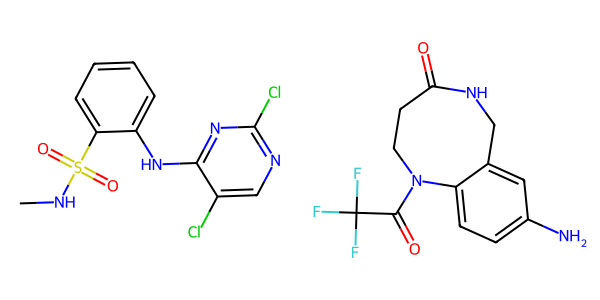

O.COc1ccc(C(=NO)c2cccc(NS(=O)(=O)N(C)C)c2)cc1.ClCCl.CCN(CC)CC.CC(=O)Cl


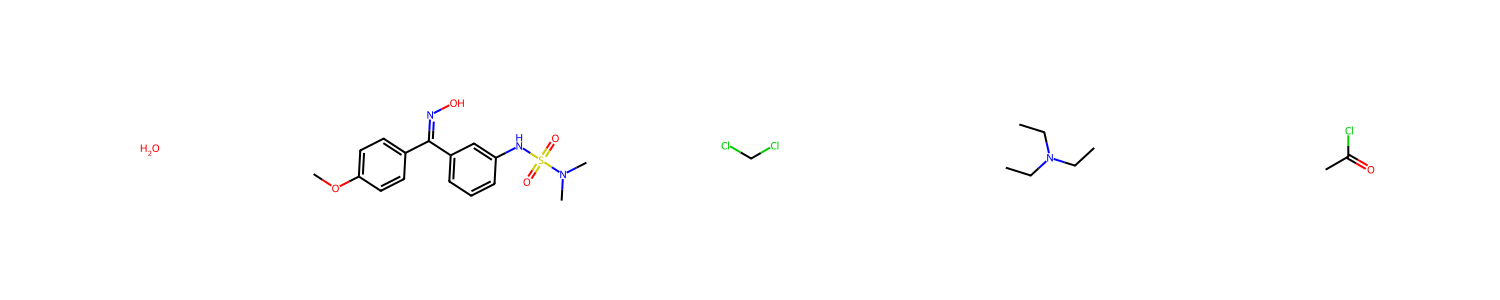

c1ccc2[nH]ccc2c1.[CH3].[K+].O.COC(=O)C([O])=O.CC(C)(C)[O-].Cl.CCOCC.CN(C)C=O


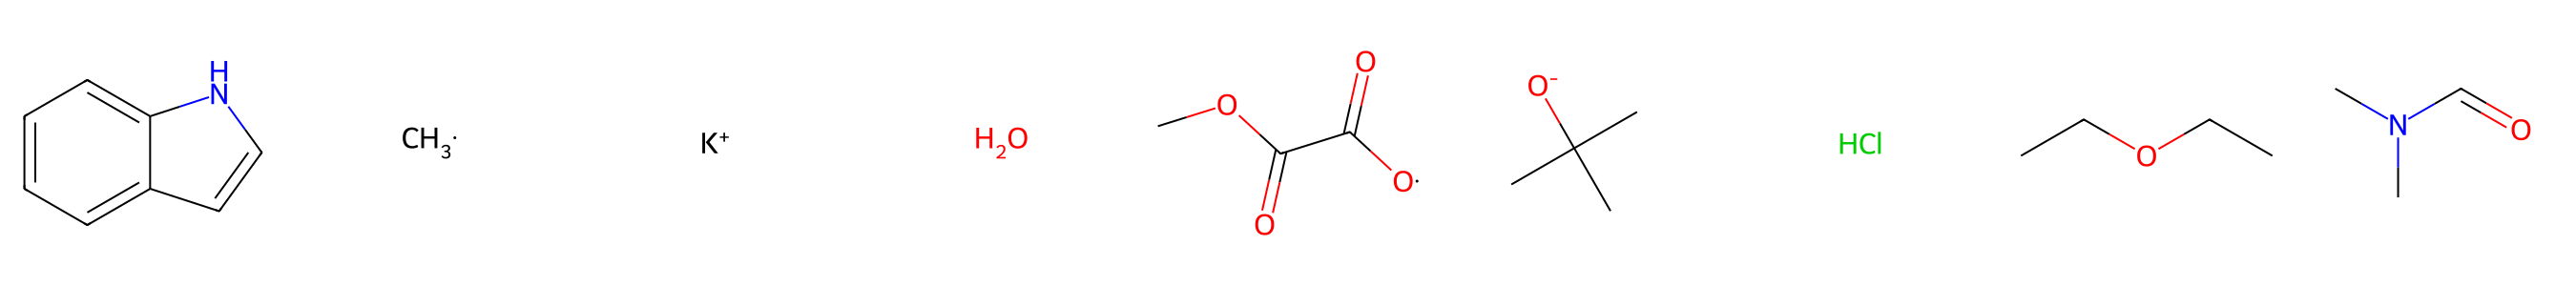

O.CCOC(=O)c1cc2cc3[nH]c(=O)[nH]c3cc2[nH]1


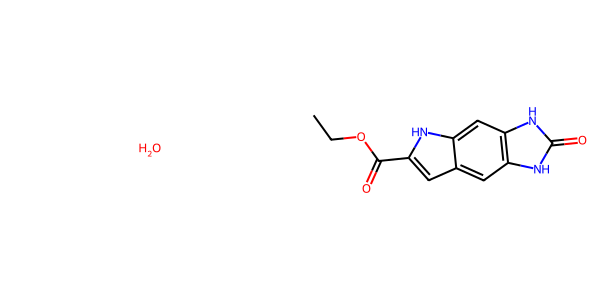

[BH4-].[Na+].O.[O].[CH]C(Oc1ccc(C(F)(F)F)cc1)c1cccc(C(F)(F)F)c1.CC(C)O


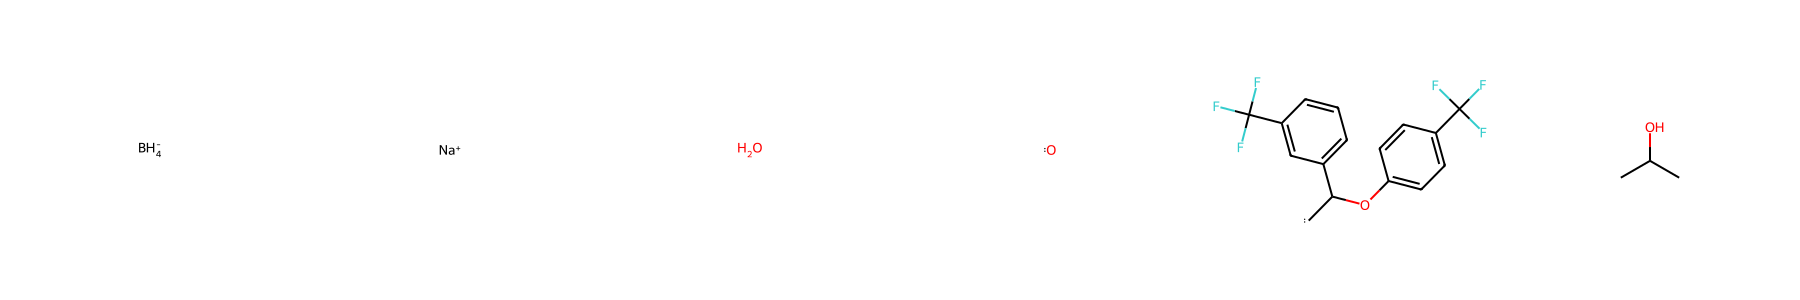

O=[C]c1cc2cc3[nH]c(=O)[nH]c3cc2[nH]1.CC[O].O


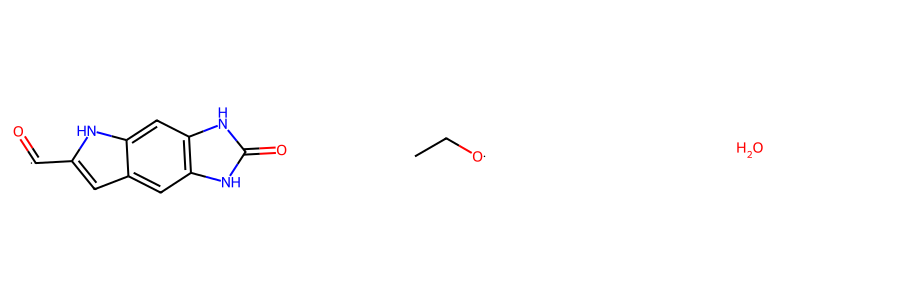

CC(=O)O.BrBr.CN1CCC23c4c5cccc4OC2C(=O)CCC3(O)C1C5


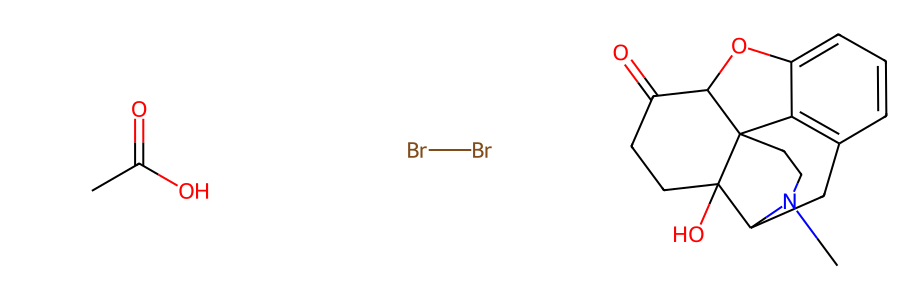

In [33]:
for i in range(len(all_y_true)):
    if all_y_true[i] == 1 and all_y_pred[i] == 1:
        print(".".join(smiles_list[i]))
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[i]]
        img = Draw.MolsToGridImage(molecules, molsPerRow=len(molecules), subImgSize=(300, 300))
        display(img)
# smiles = "CCCCC(C)I.Nc1ccccc1O"  # Ethanol

# # Convert to RDKit molecule object
# mol = Chem.MolFromSmiles(smiles)

# # Draw molecule
# Draw.MolToImage(mol)

In [34]:
data_path = 'hyperedge_2000'
encoding = 'ecfp6_feat'
gnn_model_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_2000_ecfp6_feat/best_pretrained_gnn_model.pth'
mlp_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_2000_ecfp6_feat/best_mlp_model.pth'
with_chem_ns = True
ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
chem_ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
split_path = './data_neg_balanced_smiles/splits/hyperedge_2000split2.pt'
device = 'cuda:0'
all_y_true, all_y_pred, smiles_list = get_predicted_rxn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)
#get_2D_tsne_gnn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)

0.05194805194805195


/tmp/1560437.1.gpu/ipykernel_778602/3523198079.py:118: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  specificity = specificity_metric(torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.int))


In [36]:
sum(all_y_pred)

24.0

['On1nnc2ccccc21', '[Na+]', 'O=C([O-])O', '[OH]', 'O', 'COc1cc2c(c3c1OC(C)(C)C3)C(c1cccc(N)c1)=NC(C)(C)C2', 'CCN=C=NCCCN(C)C', 'Cl', 'CC(C)(C)OC(=O)N1CCC([C]=O)CC1', 'CN(C)C=O']


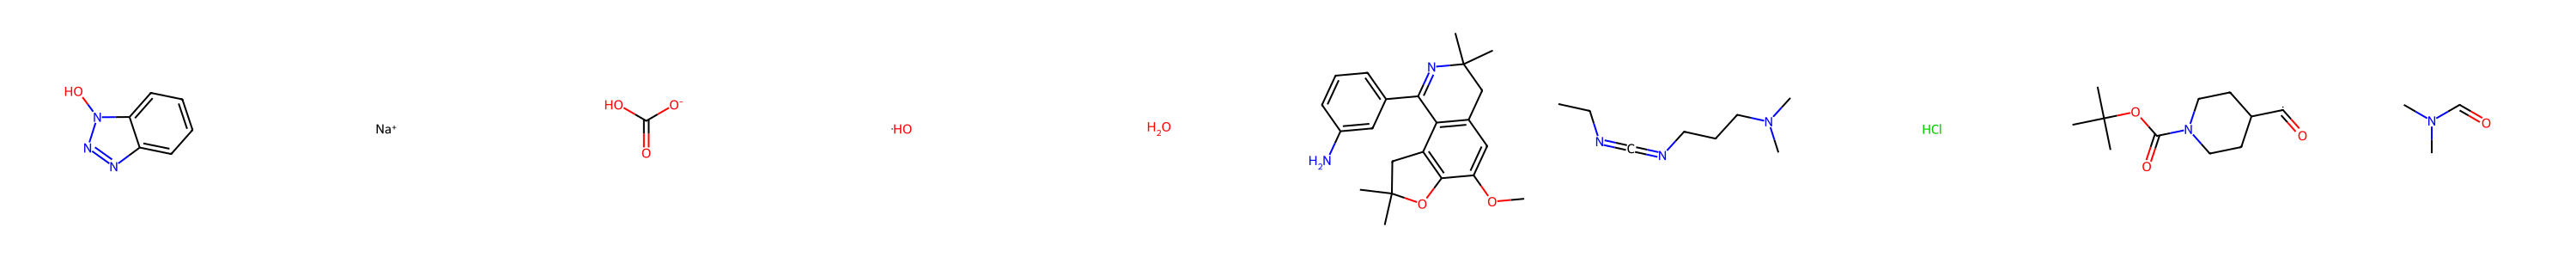

['C1CCOC1', '[Li+]', 'COC(=O)C1CN(C)CC1c1ccc(F)cc1F', '[OH-]']


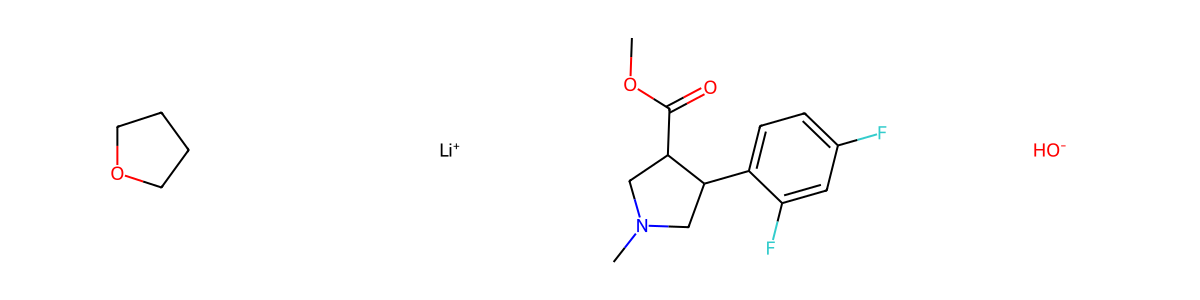

['[K+]', 'O=S(=O)(O)O', 'O=[N+]([O-])[O-]', 'CC(=O)Nc1ccc(Cl)cc1COC(C)=O']


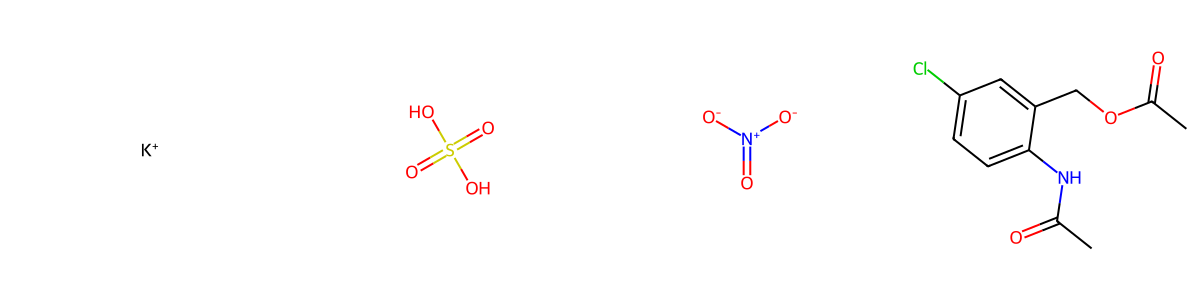

['C1CCOC1', 'CC#CC(=O)O', 'CC(C)COC(=O)Cl', 'N#Cc1cnc2ccc(N)cc2c1Nc1ccc(Oc2cccs2)c(Cl)c1', 'CN1CCOCC1', 'CN(C)C=O']


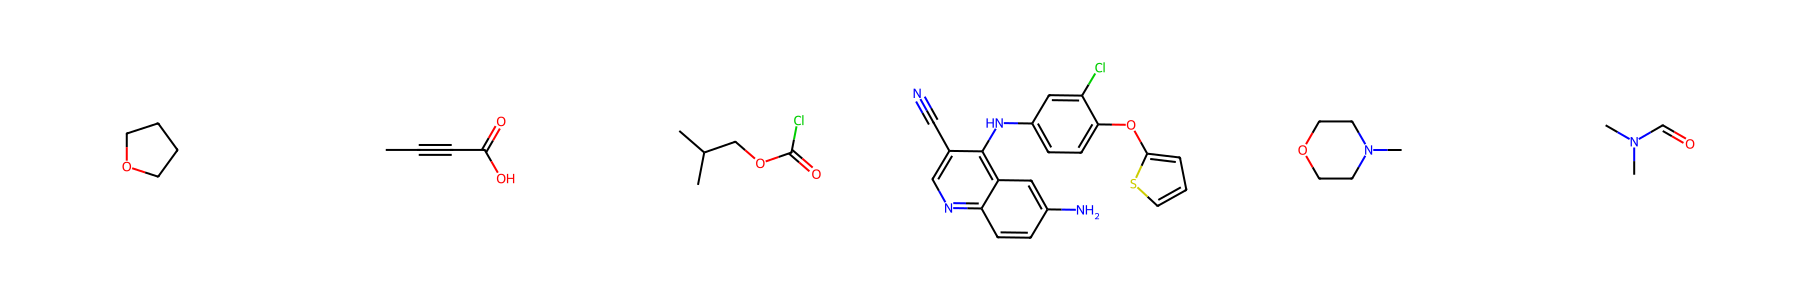

['O=[N+]([O-])C=Cc1ccccc1', 'C[NH]', 'S=C=S', 'CO', '[CH3]']


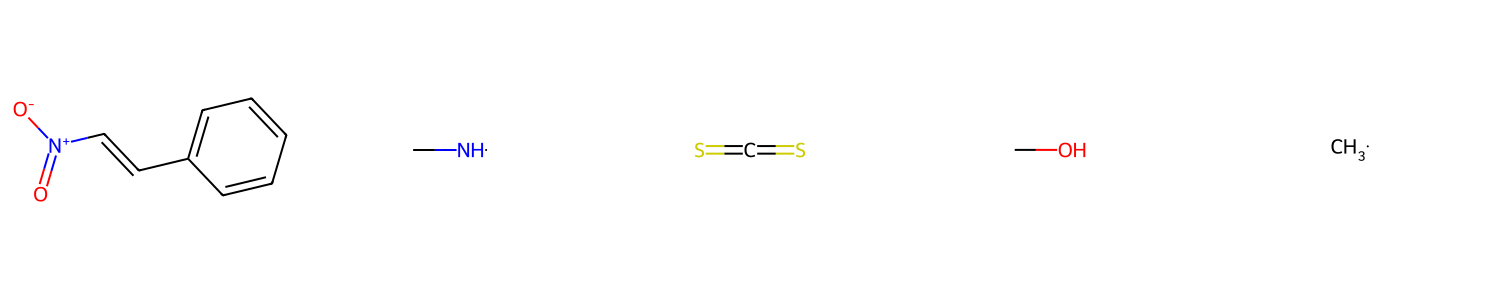

['CN(C)C', 'C=C(COCCCCCCCCCCCCCCCC)COCCCCOS(C)(=O)=O', 'CCO']


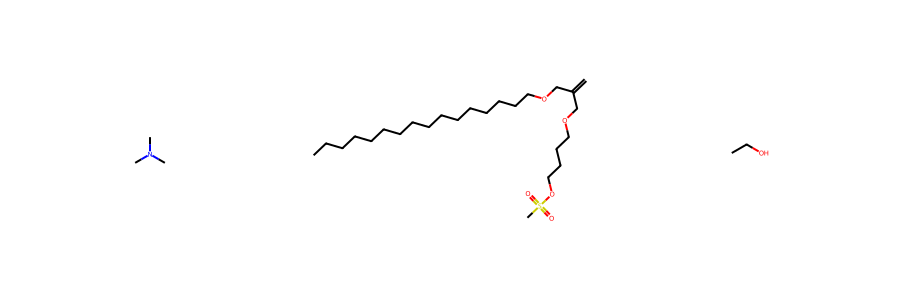

['CCO', '[K+]', 'O', 'CCOCCOc1ccc(OB([O-])[O-])cc1', 'CN(Cc1ccc(NC(=O)C2=Cc3cc(Br)ccc3S(=O)(=O)CC2)cc1)C1CCOCC1', 'Cc1ccccc1', 'O=C([O-])[O-]']


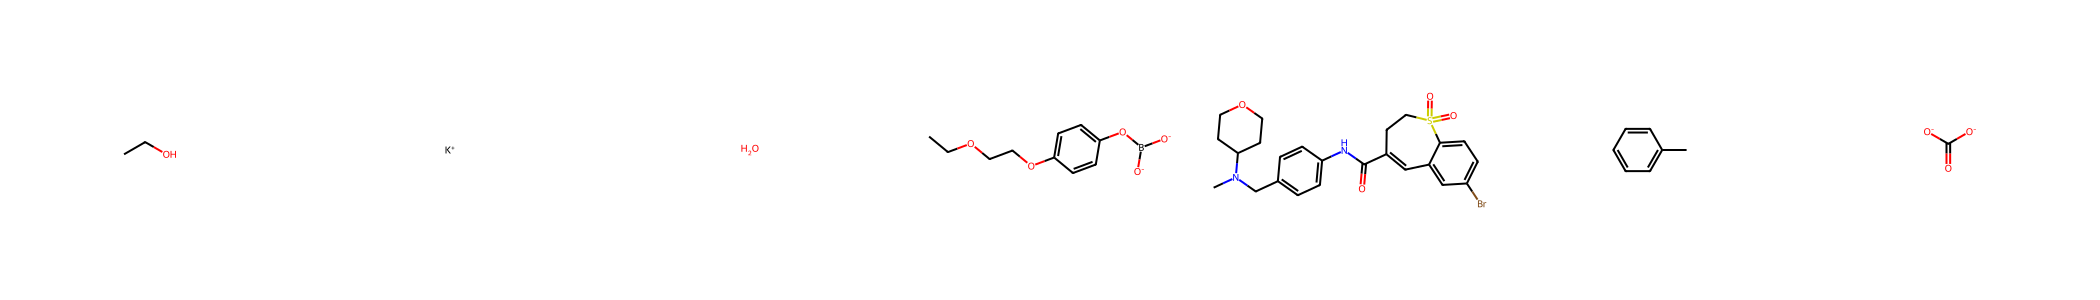

['CCCCO', 'Clc1ccc(-c2ccccc2)nn1', 'CNN']


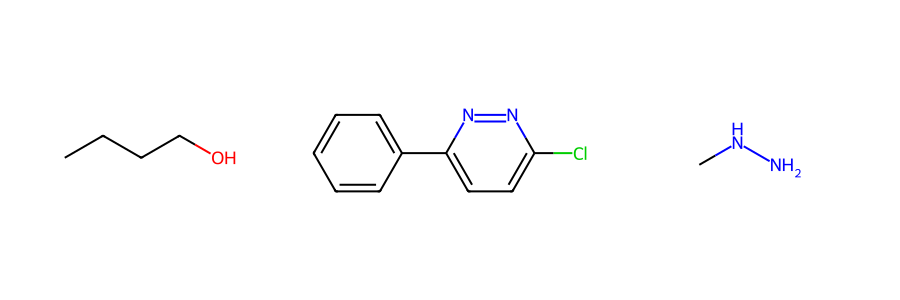

['[CH2]CC1(C(=O)OC)CCOCC1', 'ClCCl', '[CH]=O', 'CC(=O)O', 'CO', 'Nc1ccccc1', 'Cc1cc(Br)ccc1N']


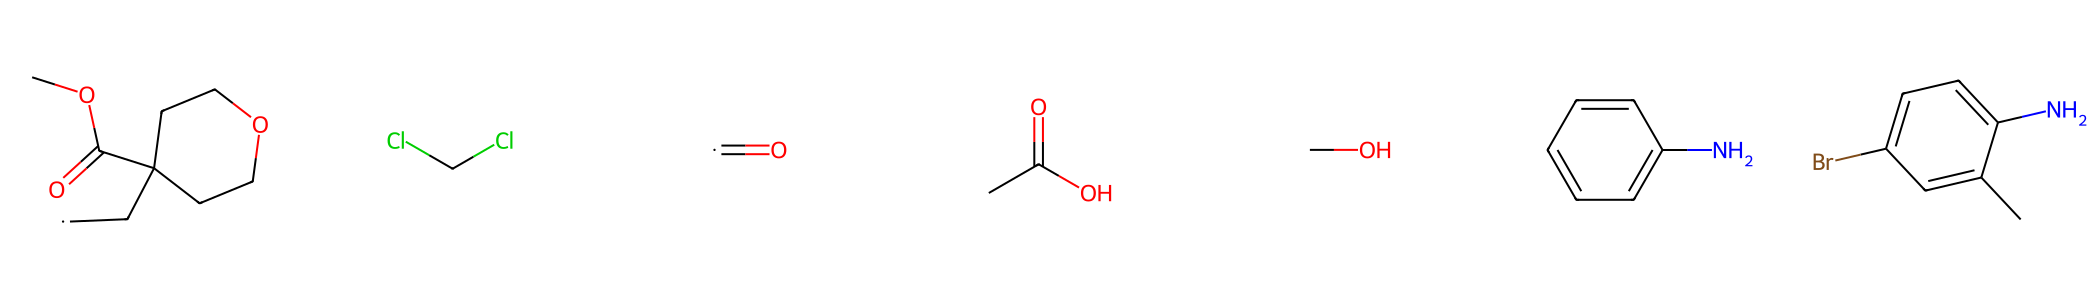

['CO', 'CCOC(=O)C1(Cc2ccccc2)CCN(CCN[C]=O)CC1', '[O]Cc1ccccc1']


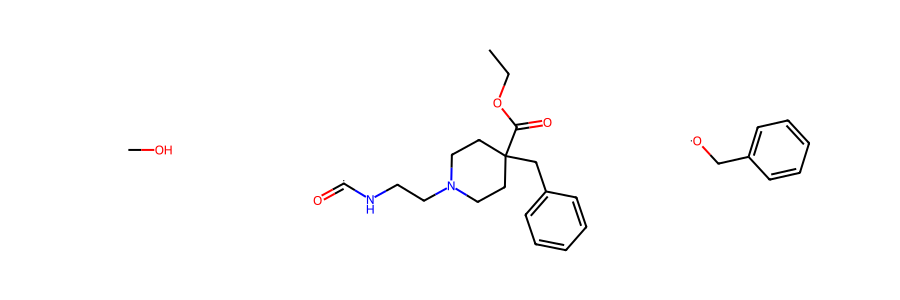

['OCCS', 'C=CCNC(C)=O']


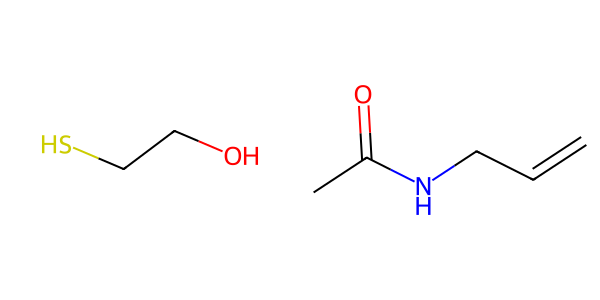

['ClCCl', 'COC(=O)c1cc(N)ccc1OC', 'CCN(C(C)C)C(C)C', 'CS(=O)(=O)Cl']


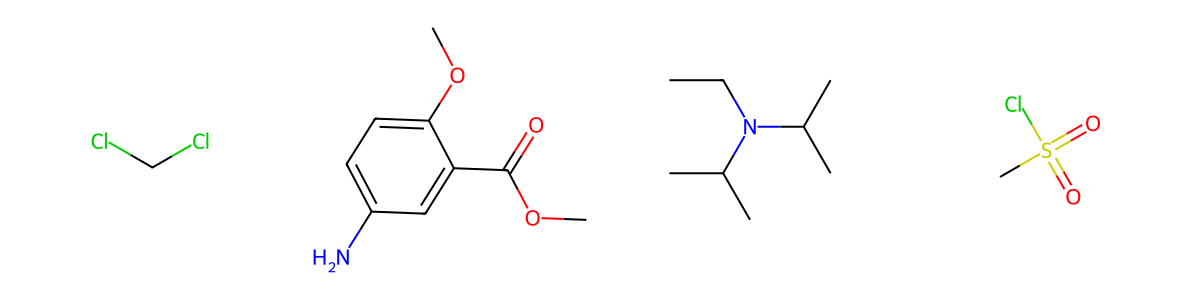

['C1CCOC1', 'Cn1nnc(C2CC(C([O])=O)CCN2C(=O)OCc2ccccc2)n1', '[OH-]', 'O', 'Cl', '[CH2]C', '[Li+]']


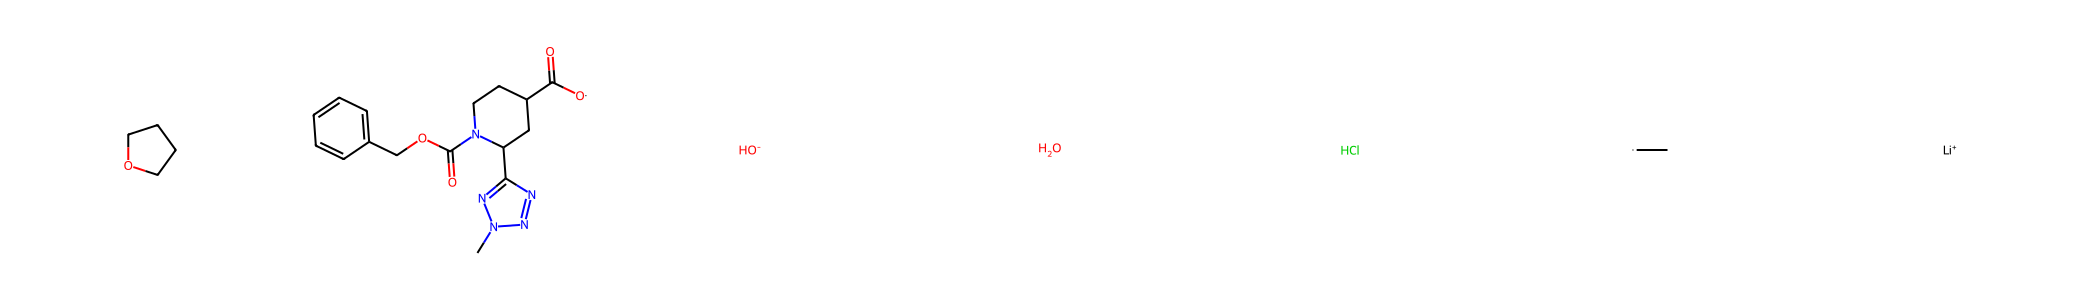

['CO', '[C]#CCCO', '[c]1ccc(C2CC2)cc1', 'O=S(=O)(O)O']


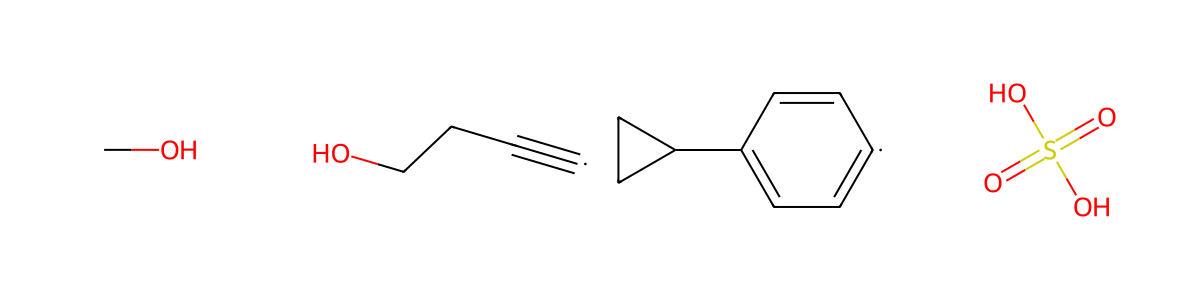

['CC(OCc1ccccc1)C(N)=O', 'O=C=NS(=O)(=O)Cl', 'CC#N']


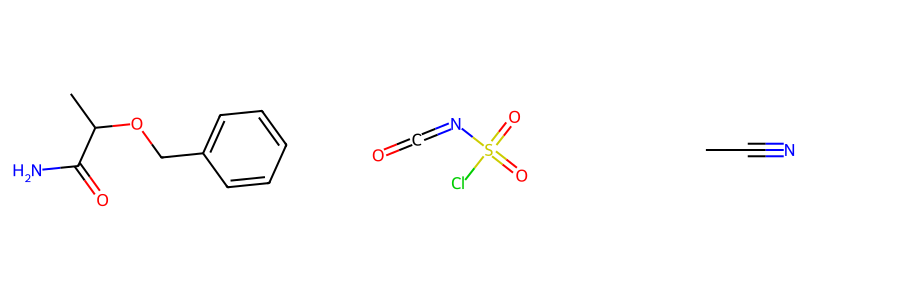

['CO', 'COC(=O)[C]C(C)OC(=O)[C]NC(C)=O']


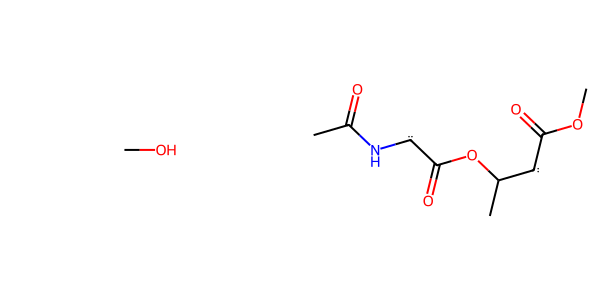

['C1CCOC1', 'O=[C]Cl', 'CCCCCC', 'Nc1ccc(Br)cc1', '[CH]=C(C)C']


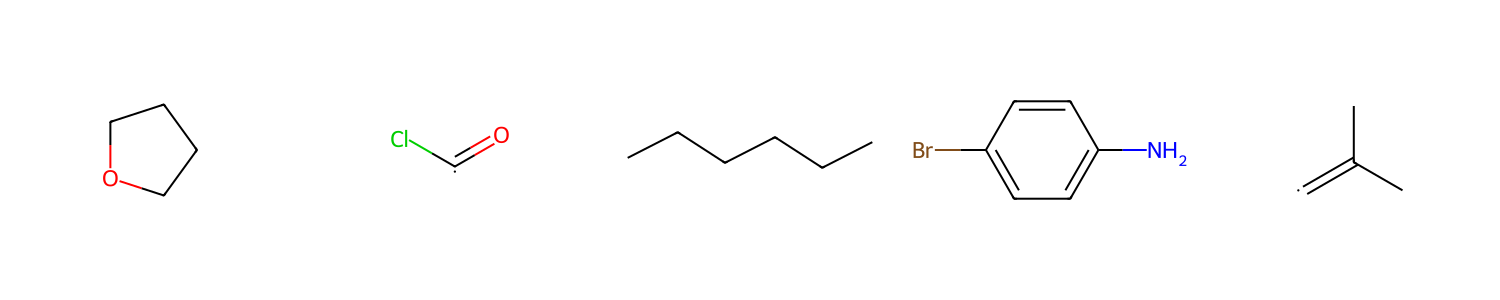

['[OH]', 'ClCCl', 'C[C](C)C', 'CC(C)C(=O)Cl', 'Cl', 'CCN(CC)CC', 'CN(C)c1ccncc1']


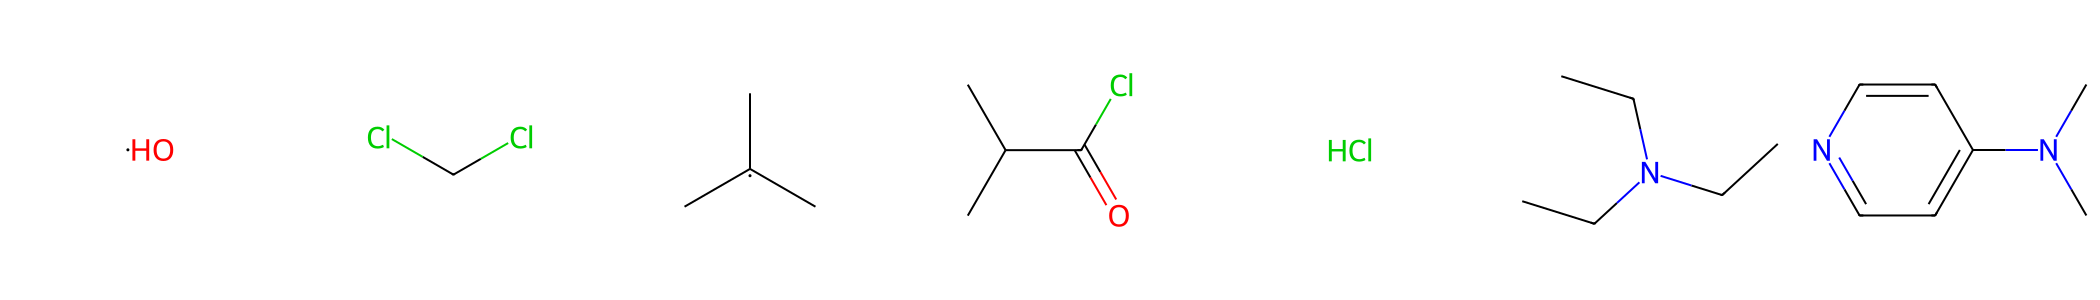

['CCCOc1c(-c2ccccc2)cc(N)cc1-c1ccccc1', 'CC(=O)c1cccc(C(C)=Nc2c(C)cc(C)cc2C)n1', 'Cc1ccccc1']


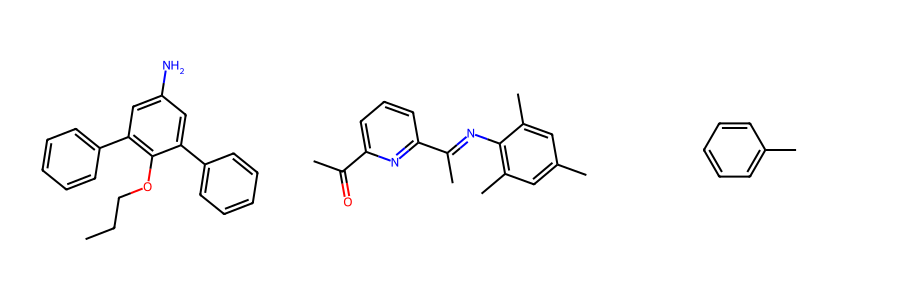

['[K+]', 'CO', 'C[Si](C)C', 'O=C([O-])[O-]', '[C]#Cc1cc(O)c2c(c1)C(C)(C)CCC2=O']


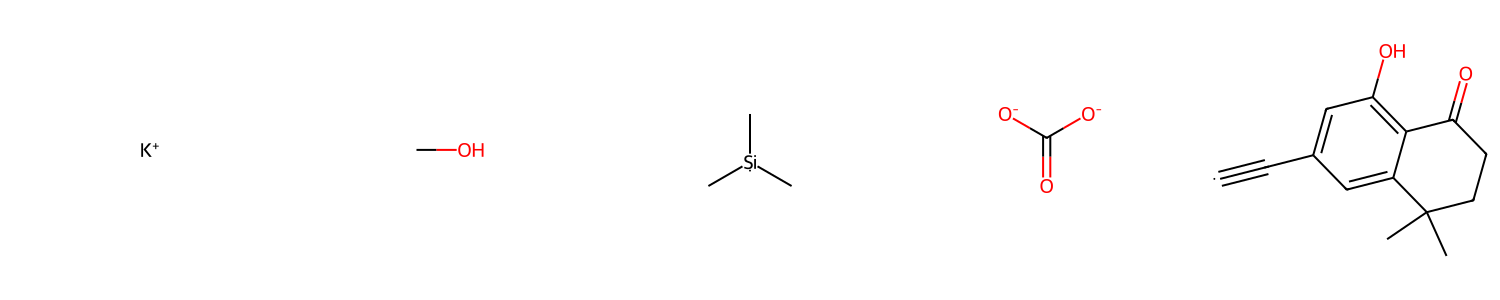

In [35]:
for i in range(len(all_y_true)):
    if all_y_true[i] == 1 and all_y_pred[i] == 1:
        print(smiles_list[i])
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[i]]
        img = Draw.MolsToGridImage(molecules, molsPerRow=len(molecules), subImgSize=(300, 300))
        display(img)

In [37]:
data_path = 'hyperedge_3000'
encoding = 'ecfp6_feat'
gnn_model_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_3000_ecfp6_feat/best_pretrained_gnn_model.pth'
mlp_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_3000_ecfp6_feat/best_mlp_model.pth'
with_chem_ns = True
ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
chem_ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
split_path = './data_neg_balanced_smiles/splits/hyperedge_3000split2.pt'
device = 'cuda:0'

all_y_true, all_y_pred, smiles_list = get_predicted_rxn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)
#get_2D_tsne_gnn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)

0.022727272727272728


/tmp/1560437.1.gpu/ipykernel_778602/3523198079.py:118: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  specificity = specificity_metric(torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.int))


In [38]:
sum(all_y_pred)

15.0

['C1COCCO1', 'O=C(OCc1ccccc1)ON1C(=O)CCC1=O', '[Na+]', 'O=C([O-])O', 'O', 'CCOC(C)=O', 'CC(C)(C)OC(=O)N1CCC(N)C1']


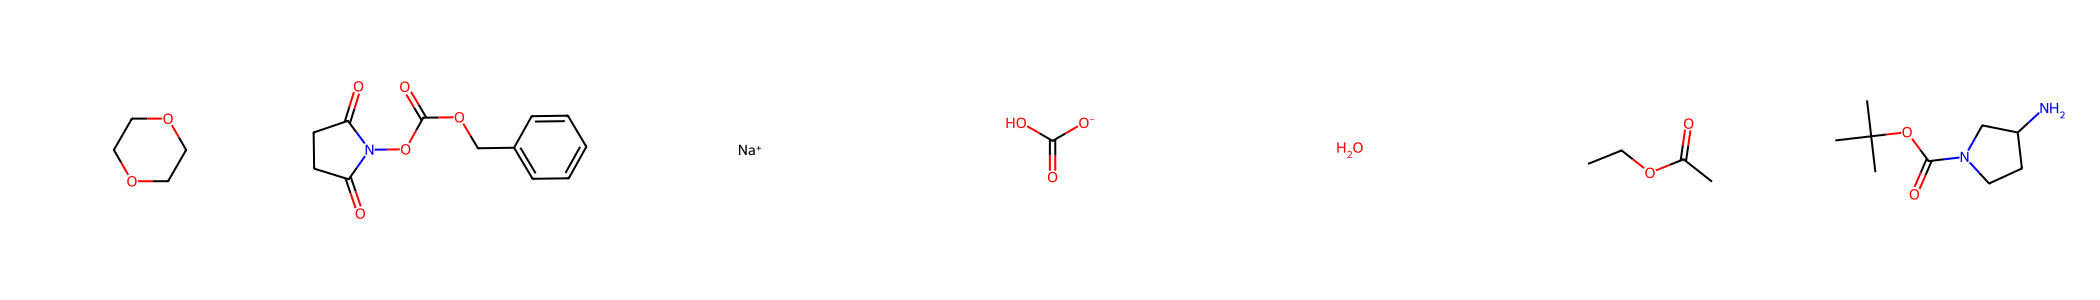

['[Na+]', 'CS(=O)(=O)OCC(F)(F)F', 'O=C(c1ccc2[nH]c(C(=O)N3CCC(F)(F)CC3)cc2c1)N1CCC(N2CCOCC2)CC1', '[H-]', 'CN(C)C=O']


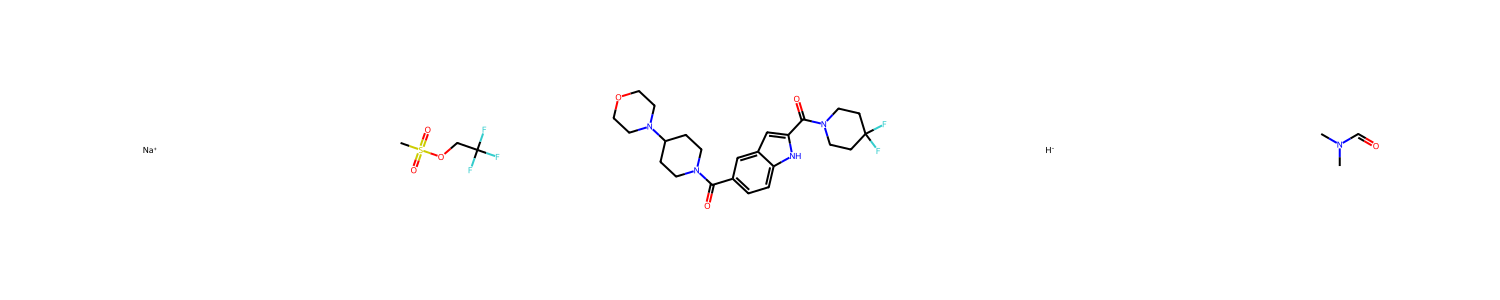

['COc1cc(-c2cnco2)cc(OC)c1Br', 'COC(C(=O)N(C)OC)c1ccc(N2CCOCC2)cc1']


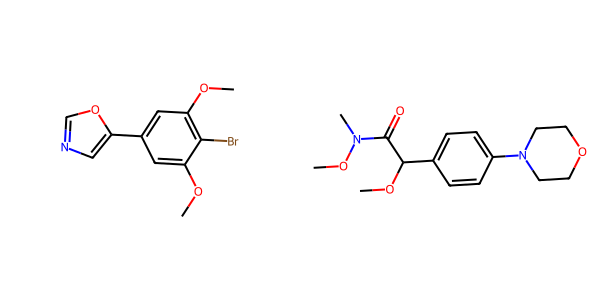

['[Na+]', 'C1=COCCC1', 'Cc1ccc(S(=O)(=O)O)cc1', 'O=C([O-])[O-]', 'C#CCO']


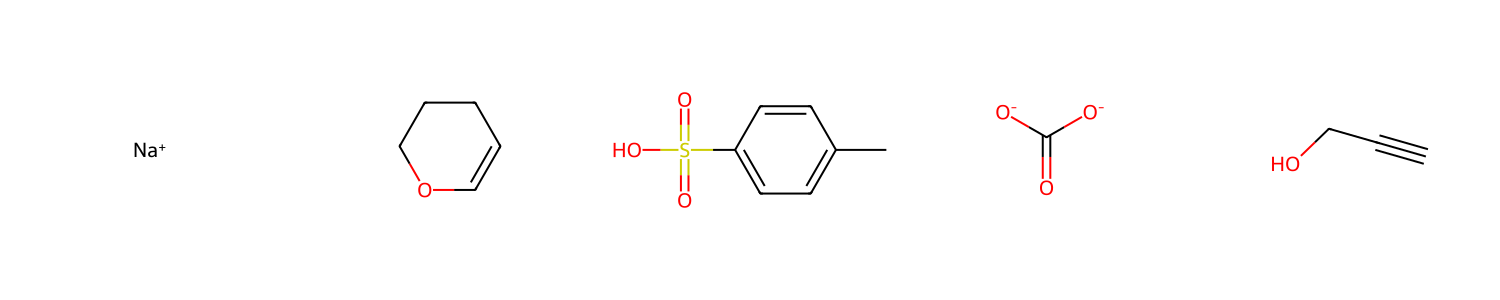

['[Na+]', 'O=C([O-])O', 'Cc1c2c(cn1C)NC(=O)CN=C2c1ccccc1', 'O=S(=O)(Cl)Cl', 'ClCCl']


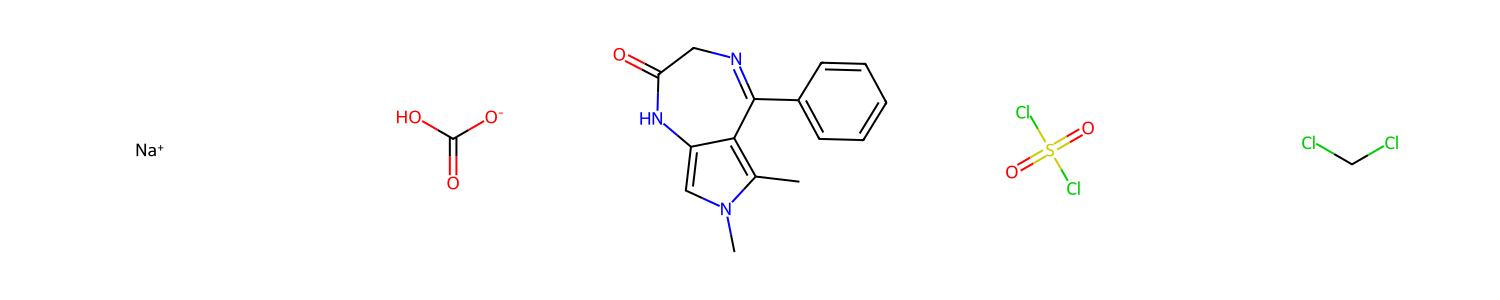

['ClCCl', 'CC(=O)O', 'CO', 'Nc1ccccc1', 'COC(=O)C1(CCC=O)CCOCC1', 'Cc1cc(Br)ccc1N']


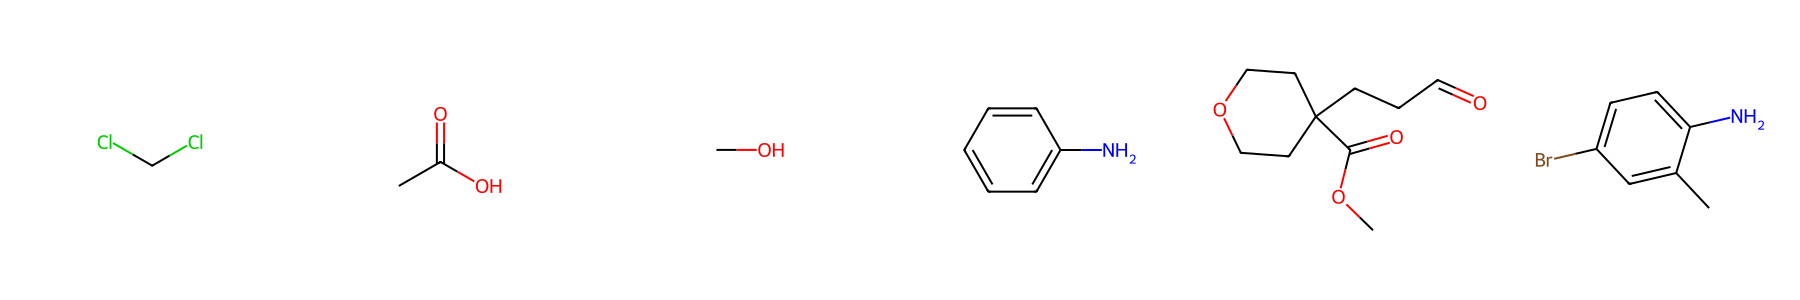

['[Na+]', '[H-]', 'O=C(NCc1ccc(SC(F)(F)F)cc1)c1ccccc1', 'FC(F)(F)Sc1ccc(CBr)cc1']


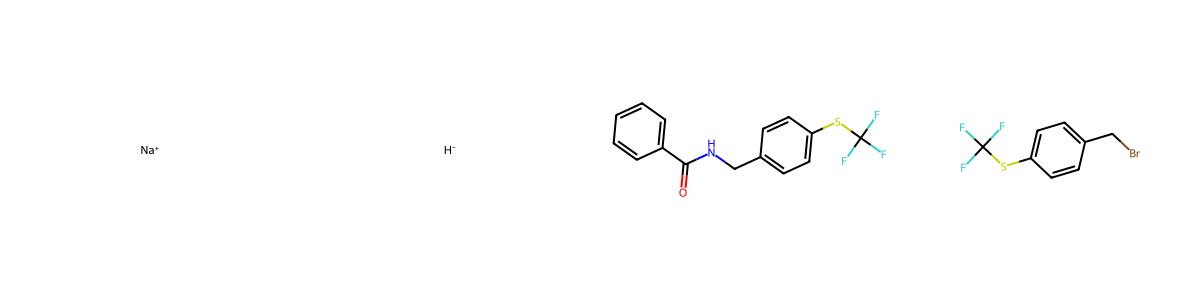

['COC(=O)N1CCC(c2cc(=O)[nH]o2)CC1c1cc(F)c(F)c(F)c1', 'Br']


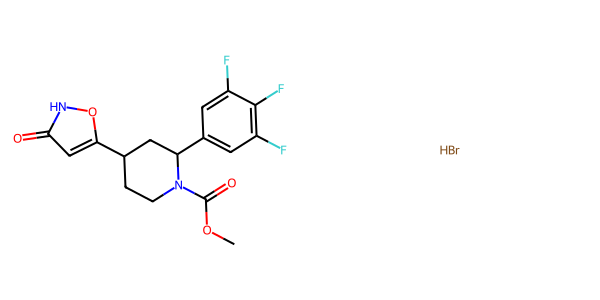

['CCOC(=O)c1ccc(N)c(C)c1F', '[OH-]', '[Na+]', 'CCO', 'Cl']


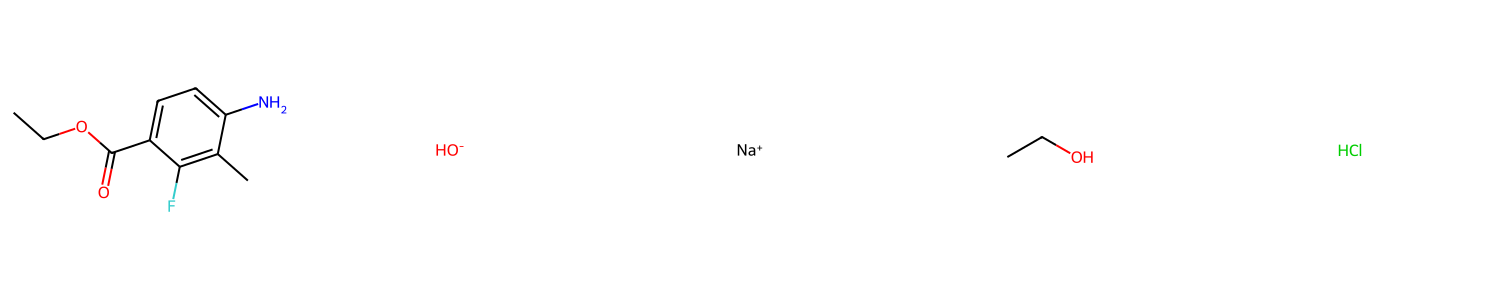

['CCCCCCCN=C=O', 'CN(C)c1ccc(NC(=O)c2ccccc2N)cc1', 'ClCCl']


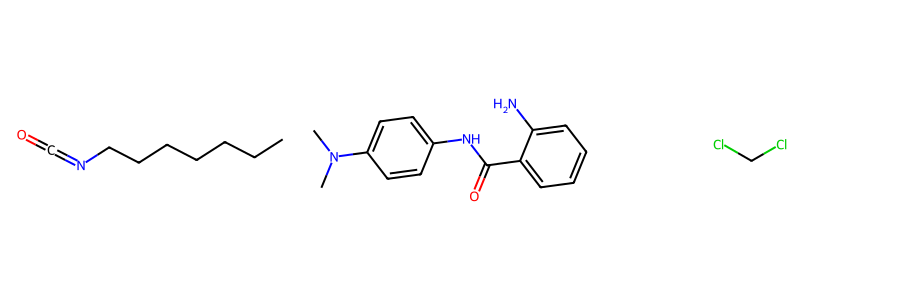

['O=S(=O)(Cl)c1cc(Cl)cc(Cl)c1', 'ClCCl', 'CCN(C(C)C)C(C)C', '[NH]CCC[CH]C(=O)O']


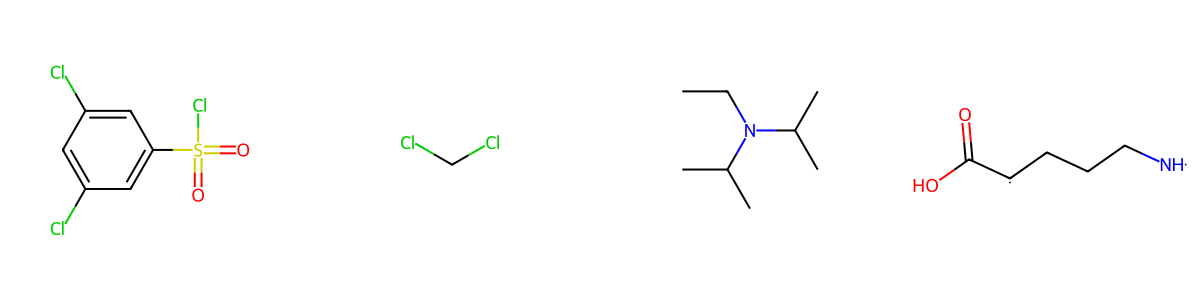

['CCCCCCCCC(O)C=CC=Cc1ccccc1OCCCC(=O)OCC', 'c1ccncc1', 'CC(=O)OC(C)=O']


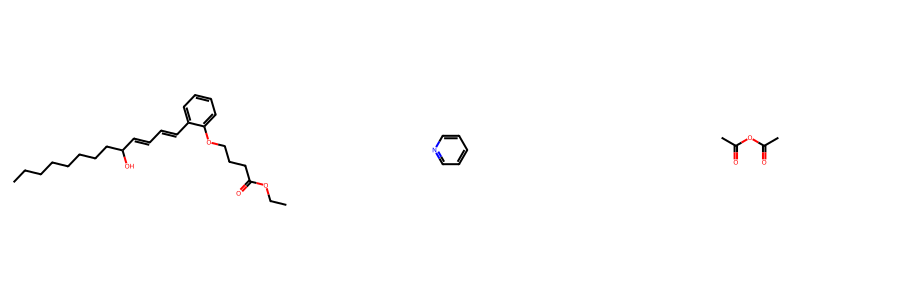

['CC(N)=O', 'Oc1ccc(O)cc1']


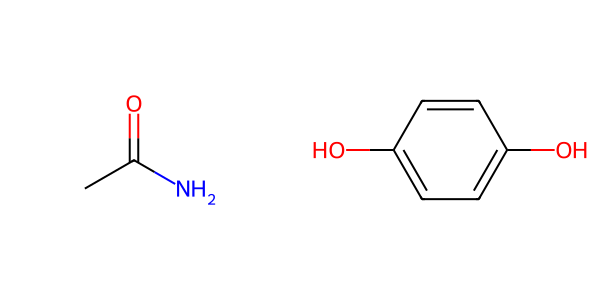

In [39]:
for i in range(len(all_y_true)):
    
    if all_y_true[i] == 1 and all_y_pred[i] == 1:
        print(smiles_list[i])
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[i]]
        img = Draw.MolsToGridImage(molecules, molsPerRow=len(molecules), subImgSize=(300, 300))
        display(img)

In [40]:
data_path = 'hyperedge_5000'
encoding = 'ecfp6_feat'
gnn_model_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_5000_ecfp6_feat/best_pretrained_gnn_model.pth'
mlp_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_5000_ecfp6_feat/best_mlp_model.pth'
with_chem_ns = True
ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
chem_ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
split_path = './data_neg_balanced_smiles/splits/hyperedge_5000split2.pt'
device = 'cuda:0'

all_y_true, all_y_pred, smiles_list = get_predicted_rxn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)
#get_2D_tsne_gnn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)

0.015706806282722512


/tmp/1560437.1.gpu/ipykernel_778602/3523198079.py:118: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  specificity = specificity_metric(torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.int))


In [41]:
sum(all_y_pred)

20.0

['Cl', 'COc1ccc(-c2cnc(N)c(Cc3ccccc3)n2)cc1', 'c1ccncc1', 'O=S(=O)(Cl)Cc1ccccc1']


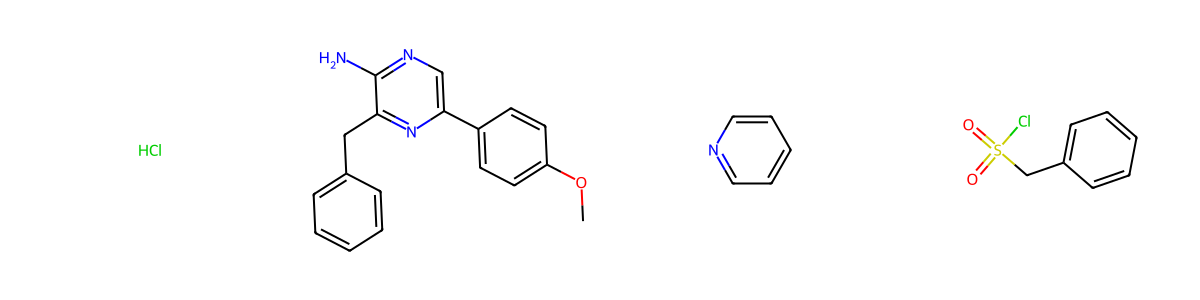

['Nc1ccc(Cl)c(-c2ccccn2)c1', 'O=[C]O', 'CN(c1cc[c]cc1)S(C)(=O)=O']


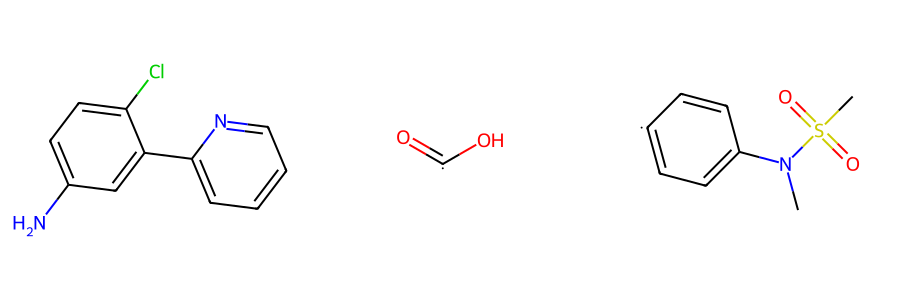

['[Na+]', 'O=S(=O)(O)O', 'O', 'O=[Cr](=O)(O)O', 'C=CC[CH]C(C)(C)N1COC(C)=C(c2ccccc2)C1=O', '[OH]', 'O=[Cr](=O)([O-])O[Cr](=O)(=O)[O-]']


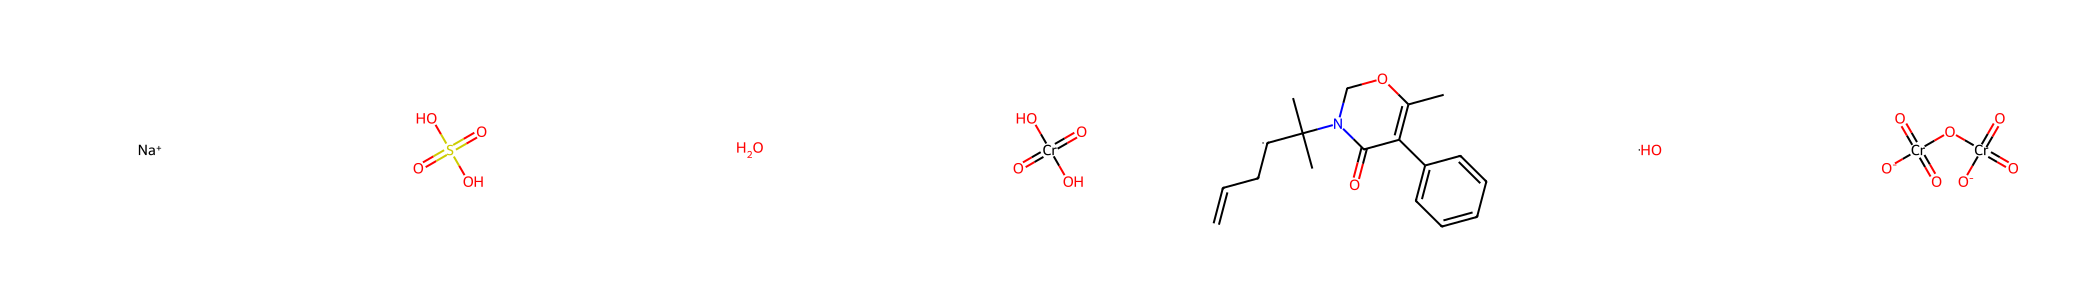

['[K+]', 'O', 'BrCc1ccccc1', 'O=C([O-])[O-]', 'O=[N+]([O-])c1cccc(O)c1', 'CN(C)C=O']


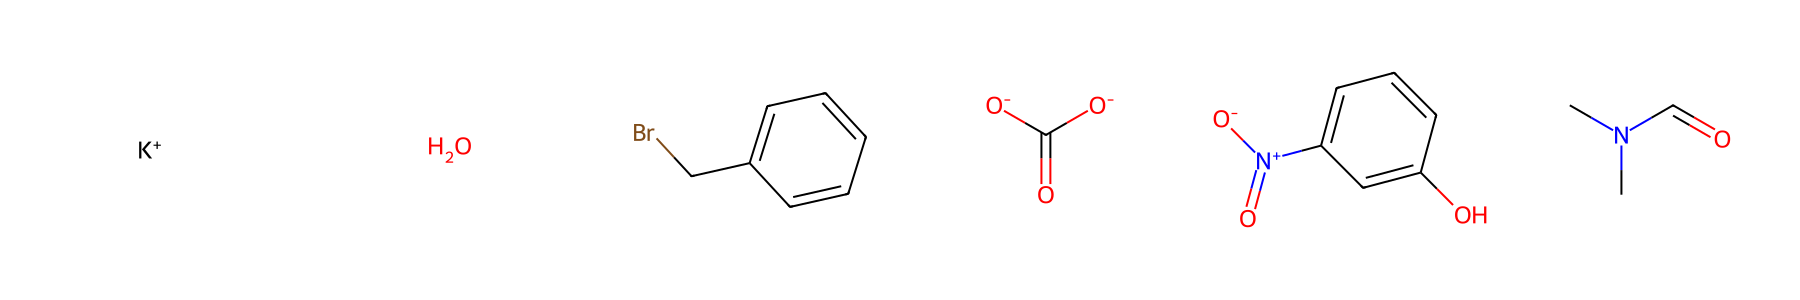

['On1nnc2ccccc21', 'O', 'CCN=C=NCCCN(C)C', 'Nc1ncc(Br)nc1C(=O)O', 'NCCN1CCOCC1', 'Cl', 'CC#N']


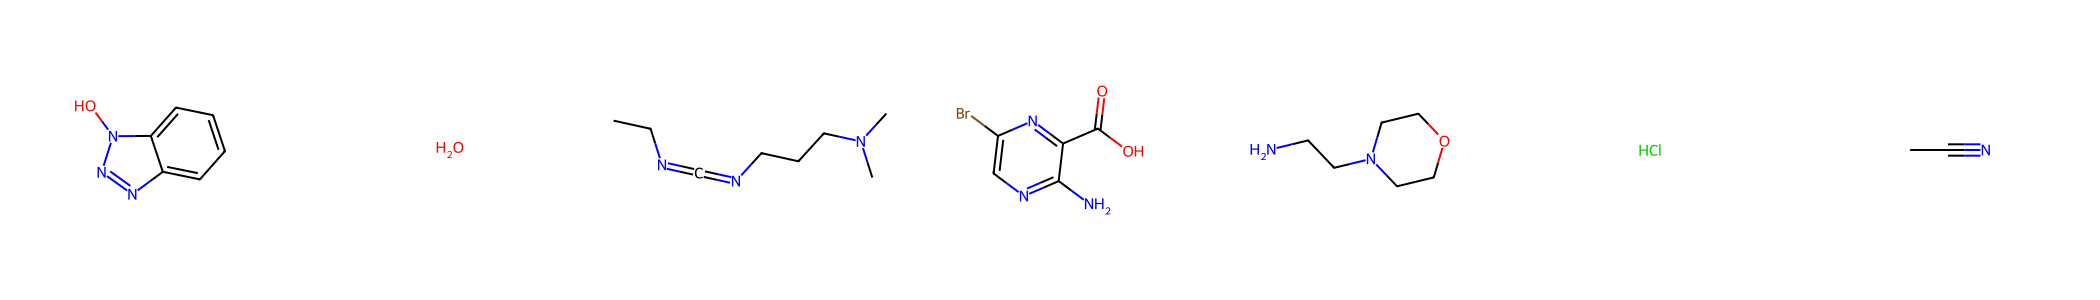

['[K+]', 'O', 'ClCCBr', 'O=C([O-])[O-]', 'CN(C)C=O', 'COc1cc2nc(-c3cccc(NC(=O)CN4CCOCC4)c3)nc(Nc3ccc4c(cnn4C(=O)OC(C)(C)C)c3)c2cc1O']


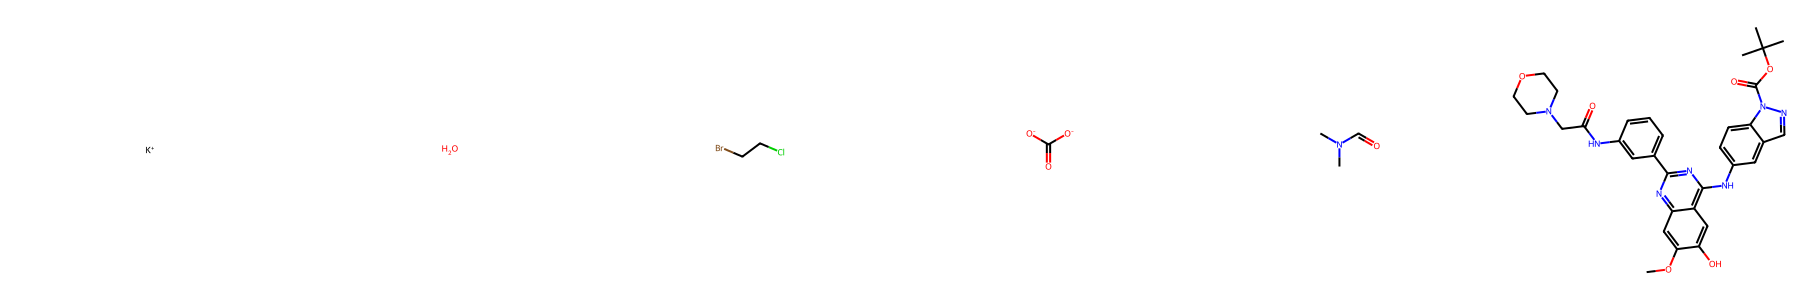

['CS(=O)(=O)c1ccc(-c2cnc(O)cn2)cc1', 'C[CH]C1CCN(c2nnn(C(C)C)n2)CC1', '[OH]']


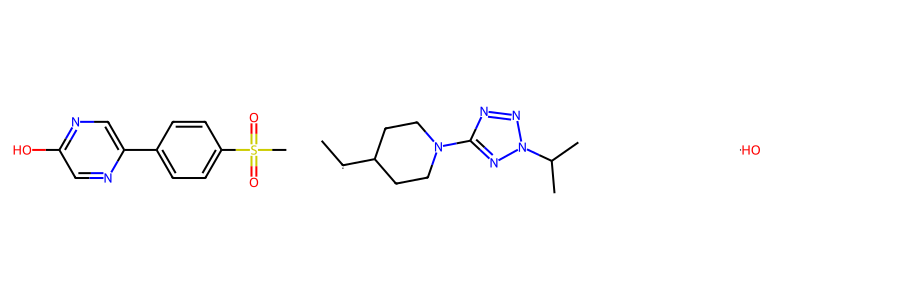

['O=C1CNCCN1', 'CC(c1ccc(-c2ccc(F)cc2)cc1)N1CCC(CCO)(c2ccc(F)cc2)OC1=O']


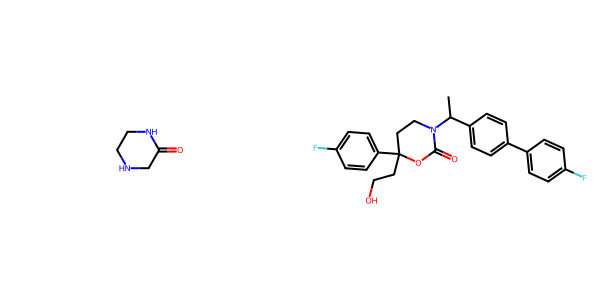

['O', 'O=CO', 'CO', '[c]1ccccc1', '[CH2]N(Cc1ccccc1)C(Cc1cc(F)ccc1F)C(O)Cc1nc(C(F)(F)F)ccc1C(=O)NC(C)(C)C', '[NH4+]']


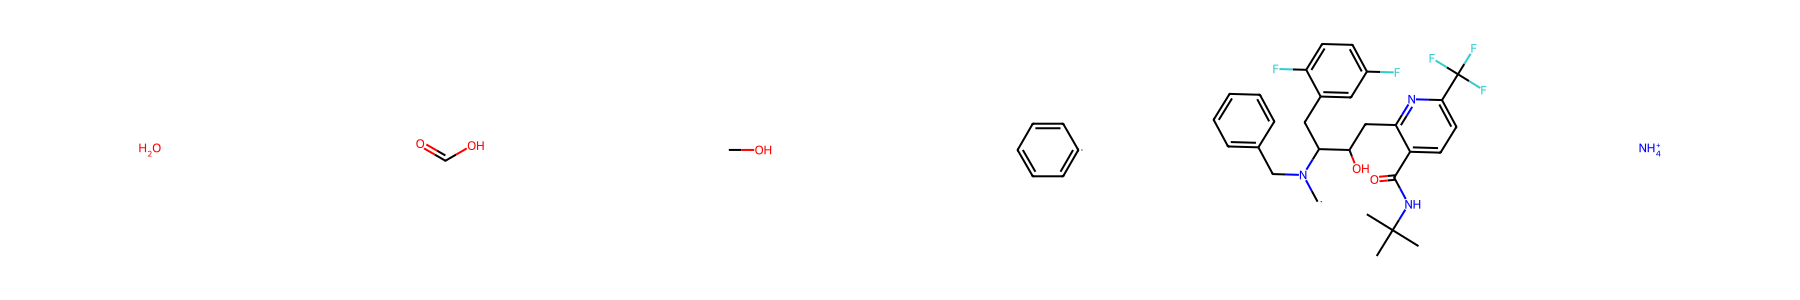

['O=C1NCC(Cc2ccccc2)O1', '[Na]', 'c1ccccc1', 'CC(=O)Cl']


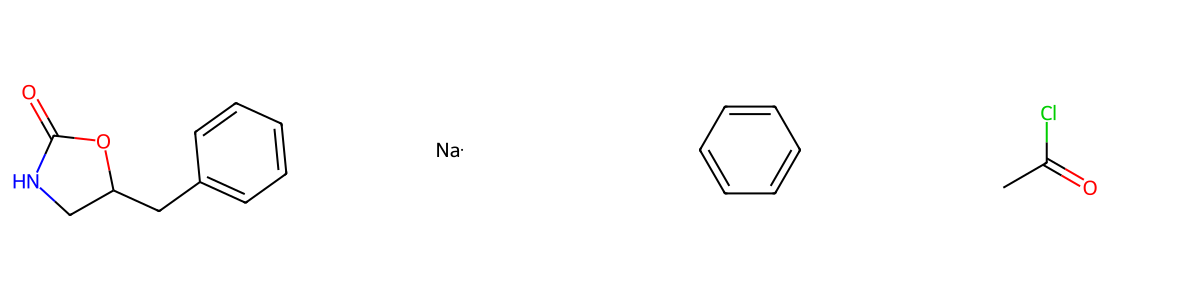

['O=C1CNCCN1', '[CH2]O', '[CH2]C1(c2ccc(F)cc2)CCN(C(C)c2ccc(-c3ccc(F)cc3)cc2)C(=O)O1']


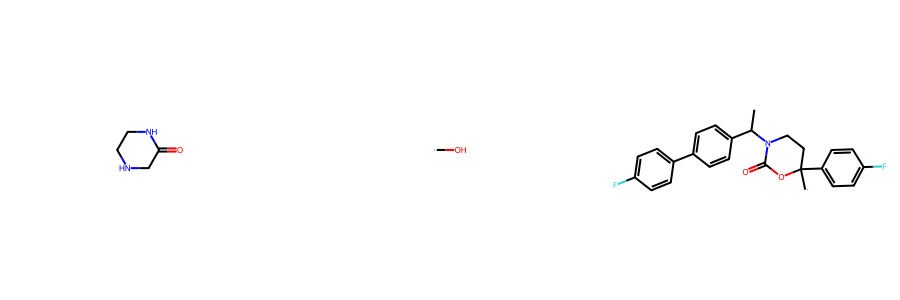

['CC1NCCc2cc(Br)ccc21', 'C[Sn](C)(C)c1ccccn1']


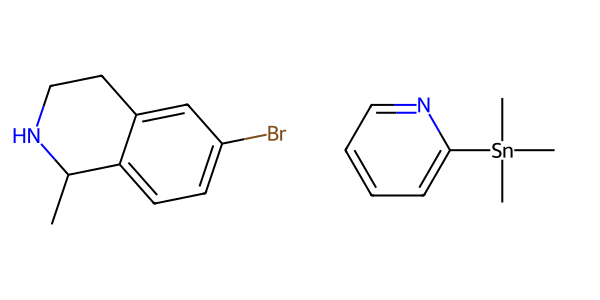

['CN(CCC=O)C(=O)Nc1nnc(C2CC2)s1', 'Cl', 'O']


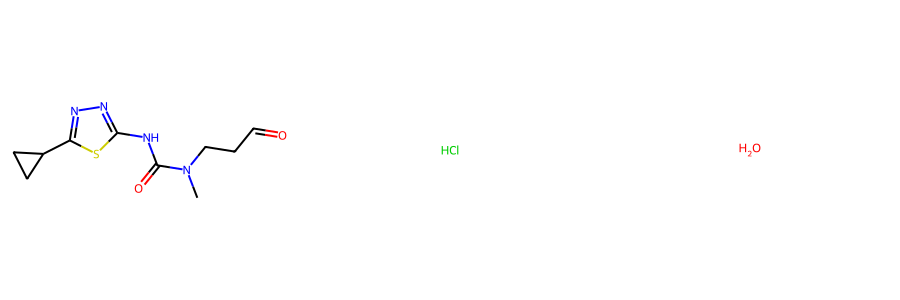

['CC(C)Cc1cc(C=O)nn1-c1ccccc1', 'NCCN1CCN(c2ccccc2)CC1']


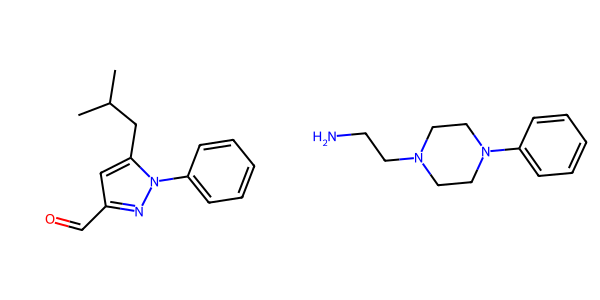

['COS(=O)(=O)OC', 'CCCCCC', 'Cc1ccccc1', 'CC(=O)Nc1ccc2nc(-c3ccc(C4CCCCC4)cc3)cc(O)c2c1']


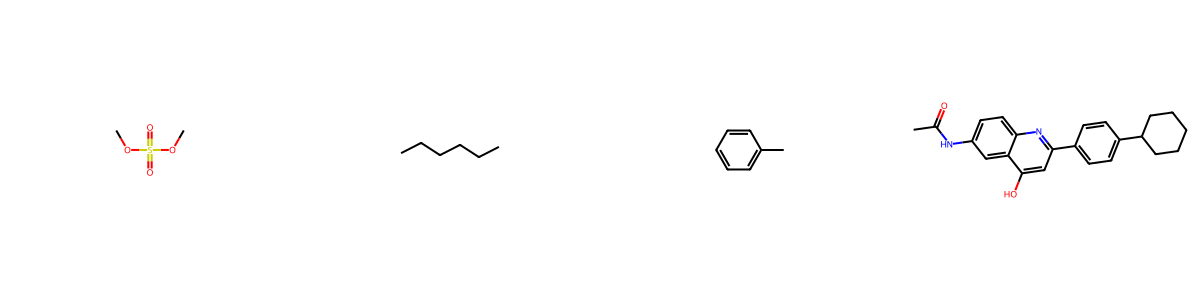

In [42]:
for i in range(len(all_y_true)):
    if all_y_true[i] == 1 and all_y_pred[i] == 1:
        print(smiles_list[i])
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[i]]
        img = Draw.MolsToGridImage(molecules, molsPerRow=len(molecules), subImgSize=(300, 300))
        display(img)

In [43]:
data_path = 'hyperedge_10000'
encoding = 'ecfp6_feat'
gnn_model_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_10000_ecfp6_feat/best_pretrained_gnn_model.pth'
mlp_path = '/afs/crc.nd.edu/user/x/xhuang2/overlapping-community-detection/exp_models/chem_neg_hyperedge_10000_ecfp6_feat/best_mlp_model.pth'
with_chem_ns = True
ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
chem_ns_data_dir = '/afs/crc.nd.edu/user/x/xhuang2/Hypergraph_Reaction_Discovery/data_neg_balanced_smiles/'
split_path = './data_neg_balanced_smiles/splits/hyperedge_10000split2.pt'
device = 'cuda:0'

all_y_true, all_y_pred, smiles_list = get_predicted_rxn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)
#get_2D_tsne_gnn(gnn_model_path, mlp_path, with_chem_ns, ns_data_dir, chem_ns_data_dir, data_path, encoding, device, split_path)

0.0005241090146750524


/tmp/1560437.1.gpu/ipykernel_778602/3523198079.py:118: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  specificity = specificity_metric(torch.tensor(y_pred), torch.tensor(y_true, dtype=torch.int))


In [44]:
sum(all_y_pred)

1.0

In [16]:
#recall_score(all_y_true, all_y_pred)
sum((np.array(all_y_pred).astype(float) > 0.5).astype(float))


1.0

['O=S(=O)(Cc1cc(F)ccc1F)c1ccc(Cl)cc1', 'CN(C)C=O', 'CC(=O)OC(C)=O', 'O']


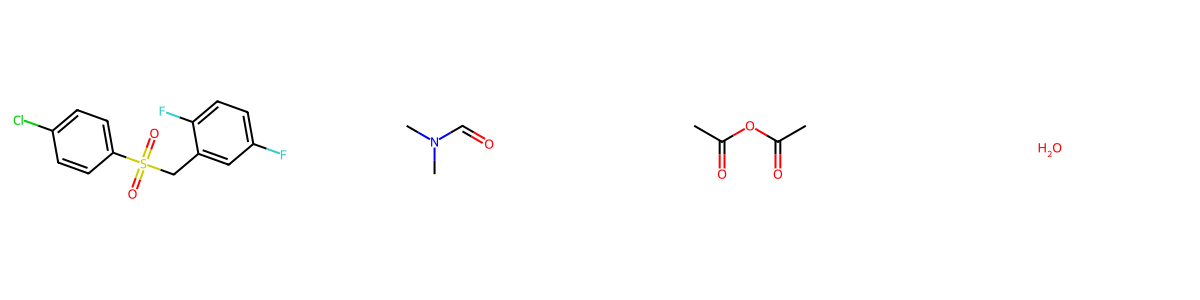

In [45]:
for i in range(len(all_y_true)):
    if all_y_true[i] == 1 and all_y_pred[i] == 1:
        print(smiles_list[i])
        molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list[i]]
        img = Draw.MolsToGridImage(molecules, molsPerRow=len(molecules), subImgSize=(300, 300))
        display(img)